In [18]:
import datetime

import colormaps
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import xarray as xr
from jetutils.anyspell import get_persistent_jet_spells, mask_from_spells_pl, subset_around_onset, get_persistent_spell_times_from_som, get_spells, extend_spells, gb_index
from jetutils.clustering import Experiment, RAW_REALSPACE, labels_to_centers
from jetutils.data import DataHandler, open_da, data_path, compute_anomalies_pl, coarsen_da, compute_anomalies_ds
from jetutils.definitions import (
    DATADIR,
    FIGURES,
    PRETTIER_VARNAME,
    YEARS,
    KAPPA,
    compute,
    get_region,
    infer_direction,
    polars_to_xarray,
    xarray_to_polars,
    labels_to_mask,
    extract_season_from_df,
    explode_rle,
    DUNCANS_REGIONS_NAMES,
    UNITS,
    N_WORKERS,
    do_rle,
    do_rle_fill_hole,
)
from jetutils.jet_finding import JetFindingExperiment, jet_integral_haversine, find_all_jets, haversine_from_dl, jet_position_as_da
from jetutils.plots import COLORS, COLORS_EXT, PINKPURPLE, Clusterplot, gather_normal_da_jets_wrapper, _gather_normal_da_jets_wrapper, make_transparent, honeycomb_panel
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from pathlib import Path
import polars.selectors as cs


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    labels = labels.cast({"time": pl.Datetime("ms")})
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "6h"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "6h"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "6h"),
    ).drop("year", "start", "end")
    return [seasons[season].explode().sort() for season in seasons.columns]
dh = DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/3")
exp_wind = Experiment(dh)
centers_kmeans, labels_kmeans = exp_wind.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
summer_daily = summer.filter(summer.dt.hour() == 0)

In [ ]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/6"))
dh_low = DataHandler.from_specs(
    "ERA5", "plev", "mid_wind", "6H", "all", None, -80, 40, 15, 80, "all"
)
ds = exp.ds.sel(time=summer)
all_jets_one_df = exp.find_jets().cast({"time": pl.Datetime("ms")})
jet_pos_da = exp.jet_position_as_da().sel(time=summer)
props_as_df = exp.props_as_df(True).cast({"time": pl.Datetime("ms")})

exp_s = Experiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/2"))
da_s = exp_s.da
da_s = da_s.sel(time=da_s.time.dt.hour == 0)

ds_ = ds.sel(time=ds.time.dt.hour == 0)
all_jets_one_df = all_jets_one_df.cast({"time": pl.Datetime("ms")})
all_jets_one_df = all_jets_one_df.with_columns(
    (pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5)
    .cast(pl.Int8)
    .alias("jet ID")
)
all_jets_one_df = all_jets_one_df.sort("time", "jet ID", "lon")

diffs = (
    props_as_df[["jet", "time", "mean_lon", "mean_lat"]]
    .group_by("jet")
    .agg(
        pl.col("time"),
        cs.numeric().diff().abs(),
        (
            pl.col("time").diff().cast(pl.Float32())
            / pl.duration(
                seconds=1, time_unit=props_as_df["time"].dtype.time_unit
            ).cast(pl.Float32())
        ).alias("dt"),
        pl.col("mean_lat").alias("actual_lat"),
    )
    .explode(cs.all().exclude("jet"))
    .sort("time", "jet", descending=[False, True])
    .with_columns(
        com_speed=(
            haversine_from_dl(pl.col("actual_lat"), pl.col("mean_lon"), pl.col("mean_lat"))
            / pl.col("dt")
        )
        .cast(pl.Float32())
    )
    .rolling("time", period="2d", offset="-1d", group_by="jet")
    .agg(pl.col("com_speed").mean())
)
props_as_df = props_as_df.drop("com_speed").join(diffs[["time", "jet", "com_speed"]], on=["time", "jet"])

ratio = all_jets_one_df.with_columns(ratio=pl.col("s_low") / pl.col("s")).group_by(["time", "jet ID"]).agg(pl.col("ratio").mean(), pl.col("is_polar").mean(), int=jet_integral_haversine(pl.col("lon"), pl.col("lat"), pl.col("s")))
polar_cutoff = 0.5
ratio = ratio.with_columns(
    pl.when(pl.col("is_polar") >= polar_cutoff)
    .then(pl.lit("EDJ"))
    .otherwise(pl.lit("STJ"))
    .alias("jet")
)
ratio_cat = ratio.group_by(["time", "jet"]).agg((pl.col("ratio") * pl.col("int")).sum() / pl.col("int").sum()).sort(["time", "jet"], descending=[False, True])

props_as_df = props_as_df.join(ratio_cat, on=["time", "jet"])
summer_filter = summer.rename("time").to_frame()
props_as_df = summer_filter.join(props_as_df, on="time")
all_jets_one_df = summer_filter.join(all_jets_one_df, on="time")

In [5]:
da_T_upper = ds["theta"] * (ds["lev"] / 1000) ** KAPPA
da_T_upper = da_T_upper.rename("T")

In [6]:
da_T_upper_anom = compute_anomalies_ds(da_T_upper, "dayofyear", False)

In [30]:
da_T = open_da(
    "ERA5",
    "surf",
    "t2m",
    "dailymean",
    "all",
    None,
    *get_region(ds),
    "all",
    "dayofyear",
    {"dayofyear": ("win", 15)},
    None,
)
da_T = compute(da_T.sel(time=summer_daily), progress_flag=True)
da_tp = open_da(
    "ERA5",
    "surf",
    "tp",
    "dailysum",
    "all",
    None,
    *get_region(ds),
    "all",
    "dayofyear",
    {"dayofyear": ("win", 15)},
    None,
)
da_tp = compute(da_tp.sel(time=summer_daily), progress_flag=True)
da_apvs = open_da(
    "ERA5",
    "thetalev",
    "apvs",
    "dailyany",
    "all",
    None,
    *get_region(ds),
    "all",
    "dayofyear",
    {"dayofyear": ("win", 15)},
    None,
)
da_apvs = compute(da_apvs.sel(time=summer_daily), progress_flag=True)
da_cpvs = open_da(
    "ERA5",
    "thetalev",
    "cpvs",
    "dailyany",
    "all",
    None,
    *get_region(ds),
    "all",
    "dayofyear",
    {"dayofyear": ("win", 15)},
    None,
)
da_cpvs = compute(da_cpvs.sel(time=summer_daily), progress_flag=True)
long_names = {
    "t_up": "Upper level temperature [K]",
    "t2m": "2m temperature [K]",
    "tp": "Daily accum. precip. [mm]",
    "apvs": r"Anticyclonic PV streamer freq [$\%$]",
    "cpvs": r"Cyclonic PV streamer freq [$\%$]",
}

[########################################] | 100% Completed | 19.73 s
[########################################] | 100% Completed | 16.51 s
[########################################] | 100% Completed | 44.08 s
[########################################] | 100% Completed | 55.04 s


# Define all jet spells once

In [50]:
spells_from_jet_daily_stj_cs = get_persistent_jet_spells(
    props_as_df,
    "com_speed",
    jet="STJ",
    q=0.8,
    daily=True,
    minlen=datetime.timedelta(days=6),
    fill_holes=datetime.timedelta(hours=24),
)
spells_from_jet_daily_edj_cs = get_persistent_jet_spells(
    props_as_df,
    "com_speed",
    jet="EDJ",
    q=0.9,
    daily=True,
    minlen=datetime.timedelta(days=6),
    fill_holes=datetime.timedelta(hours=24),
)
spells_list = {
    "STJ adv. spe": spells_from_jet_daily_stj_cs.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")}),
    "EDJ adv. spe": spells_from_jet_daily_edj_cs.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")}),
}
for na, spells_ in spells_list.items():
    print(na, spells_["spell"].max())


STJ adv. spe 20
EDJ adv. spe 17


# compare with SOM persistence

In [51]:
da_summer = dh.da.sel(time=summer.to_numpy())
dh_summer = DataHandler.from_basepath_and_da(
    exp_wind.path.parent, da_summer, save_da=True
)
exp_summer = Experiment(dh_summer)
nx, ny, n_pca = 4, 4, 200
net, centers, labels = exp_summer.som_cluster(
    nx,
    ny,
    n_pca,
    sigma=1.5,
    sigmaN=1e-5,
    train_kwargs=dict(num_epochs=20),
    init="pca",
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
from sklearn.metrics import pairwise_distances

dists = pairwise_distances(net.weights)
spells = get_persistent_spell_times_from_som(
    labels, dists, 0, 24, nt_before=0, nojune=True, daily=True
)
spells = spells.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")})

labels_daily = labels.sel(time=labels.time.dt.hour == 0)
mask_daily = labels_to_mask(labels_daily)
jets_daily = all_jets_one_df.filter(pl.col("time").is_in(summer_daily))

spells_per_cluster = (
    spells.filter(pl.col("relative_index") == 0).group_by("value").len()
)
spells_per_cluster = (
    pl.Series("value", np.arange(net.n_nodes))
    .to_frame()
    .join(spells_per_cluster, how="left", on="value")
    .fill_null(0)
)
numbering = [
    f"{numb + 1}, {spells_per_cluster[int(numb), 'len']}" for numb in range(net.n_nodes)
]

props_as_df_anoms = compute_anomalies_pl(props_as_df, ("jet",), 31, True)
props_masked = mask_from_spells_pl(
    spells, props_as_df_anoms, time_before=datetime.timedelta(days=5)
)
props_masked_ = (
    props_masked.group_by(pl.col("value"), pl.col("relative_index"), pl.col("jet"))
    .mean()
    .rename({"value": "cluster"})
)
indexer = (
    pl.Series("cluster", np.arange(net.n_nodes))
    .to_frame()
    .join(
        props_masked[:, ["jet", "relative_index"]].unique(("jet", "relative_index")),
        how="cross",
    )
    .sort("cluster", "jet", "relative_index")
)
props_masked_ = indexer.join(
    props_masked_, how="left", on=["cluster", "jet", "relative_index"]
)
spells_list[f"SOM"] = spells
spells_list_extended = spells_list.copy()
for cluster in range(net.n_nodes):
    spells_list_extended[f"SOM cluster {cluster}"] = spells.filter(
        pl.col("value") == cluster
    )

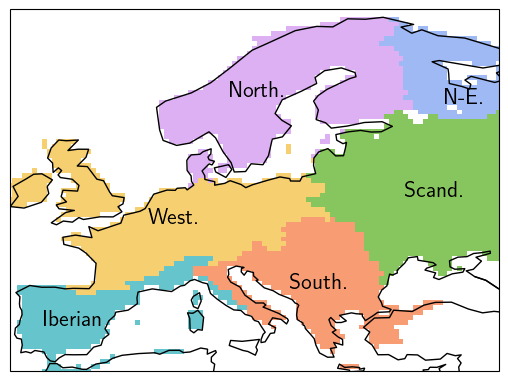

In [52]:
clusters_da = np.abs(xr.open_dataarray(Path(DATADIR, "ERA5/heatwaves_duncan/cluster_df.nc")).load())
clusters_da = clusters_da.interp(lat=np.arange(32, 72, 0.5), method="nearest")
clu = Clusterplot(1, 1, (-10, 40, 35, 72), row_height=5)
cmap = colormaps.pastel
ax = clu.axes[0]
unique_clusters = np.arange(1, 7)
norm = BoundaryNorm(np.arange(cmap.N) + 0.5, cmap.N)
clusters_da.plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False
)
for j in range(6):
    lo = clusters_da.lon.where(clusters_da==(j + 1)).mean().item() - j - 2 * (j == 0) + 2 * (j == 2) + 1.5 * (j == 1) - (j == 4)
    la = clusters_da.lat.where(clusters_da==(j + 1)).mean().item() - (j == 5) * 2
    color = "black"
    ax.text(lo, la, DUNCANS_REGIONS_NAMES[j], ha="center", va="center", fontweight="bold", color=color)

plt.savefig(f"{FIGURES}/jet_persistence/regions.png")
from jetutils.anyspell import regionalize
region_ts = regionalize(da_T, clusters_da, ["time"])

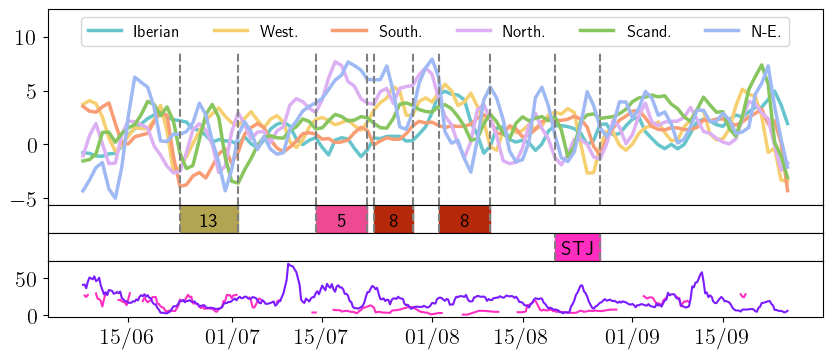

In [53]:
from matplotlib.dates import DateFormatter
from matplotlib.style import context as mstylecont, available as mstyleavail
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("axes", titlesize=16)
plt.rc("legend", fontsize=12)
plt.rc("font", size=16)
plt.rc("text", usetex=True)
plt.rc("savefig", dpi=300)

year = 2018
spell_som = spells_list['SOM'].filter(pl.col("time").dt.year() == year)
spell_stj = spells_list['STJ adv. spe'].filter(pl.col("time").dt.year() == year)
spell_edj = spells_list['EDJ adv. spe'].filter(pl.col("time").dt.year() == year)
fig, (ax, ax1, ax2, ax3) = plt.subplots(4, 1, gridspec_kw=dict(hspace=0), height_ratios=[0.7, 0.1, 0.1, 0.2], sharex="all", figsize=(10, 4))
colors = colormaps.pastel(np.linspace(0, 1, colormaps.pastel.N))[:6]
pers_period = region_ts.filter(pl.col("time").dt.year() == year)
props_thatyear = props_as_df.filter(pl.col("time").dt.year() == year)
for reg, subdf in pers_period.sort("region").group_by("region", maintain_order=True):
    reg = reg[0]
    ax.plot(subdf["time"], subdf["t2m"], color=colors[reg - 1], lw=2.5, label=DUNCANS_REGIONS_NAMES[reg - 1])
ax.xaxis.set_major_formatter(DateFormatter(r"%d/%m"))
ylim = ax.get_ylim()
ylim1 = ax1.get_ylim()
for spell_id, subspelldf in spell_stj.group_by("spell"):
    ax2.fill_between(subdf["time"], ylim1[0], ylim1[1], where=subdf["time"].is_in(subspelldf["time"]), color=COLORS[2])
    ax2.text(subspelldf["time"].mean(), 0.4, "STJ", ha="center", va="center", fontsize=14)
    ax.vlines(subspelldf["time"][0, -1], *ylim, color="grey", ls="dashed")
    ax2.vlines(subspelldf["time"][0, -1], *ylim1, color="grey", ls="dashed")
for spell_id, subspelldf in spell_edj.group_by("spell"):
    ax2.fill_between(subdf["time"], ylim1[0], ylim1[1], where=subdf["time"].is_in(subspelldf["time"]), color=COLORS[1])
    ax2.text(subspelldf["time"].mean(), 0.4, "EDJ", ha="center", va="center", fontsize=14)
    ax.vlines(subspelldf["time"][0, -1], *ylim, color="grey", ls="dashed")
    ax2.vlines(subspelldf["time"][0, -1], *ylim1, color="grey", ls="dashed")
som_colors = colormaps.cet_c_mrybm_35(np.linspace(0.1, 0.9, net.n_nodes))
for spell, subsomdf in spell_som.group_by("spell"):
    cluster = subsomdf["value"][0]
    ax1.fill_between(subdf["time"], ylim1[0], ylim1[1], where=subdf["time"].is_in(subsomdf["time"]), color=som_colors[cluster])
    ax1.text(subsomdf["time"].mean(), 0.4, f"{cluster}", ha="center", va="center", fontsize=14)
    ax.vlines(subsomdf["time"][0, -1], *ylim, color="grey", ls="dashed")
    ax1.vlines(subsomdf["time"][0, -1], *ylim1, color="grey", ls="dashed")
ax1.set_yticks([])
ax2.set_yticks([])
ax.set_ylim(ylim[0], ylim[1] + 4)
ax.legend(ncol=6, loc="upper center")
props_stj = props_thatyear.filter(pl.col("jet") == "STJ")
props_edj = props_thatyear.filter(pl.col("jet") == "EDJ")

ax3.plot(props_stj["time"], props_stj.with_columns(com_speed=pl.when(pl.col("com_speed") > 30).then(None).otherwise("com_speed"))["com_speed"], color=COLORS[2])
ax3.plot(props_edj["time"], props_edj["com_speed"], color=COLORS[1])
fig.savefig(f"{FIGURES}/jet_persistence/case_study.png")

In [54]:
hws = get_spells(region_ts, pl.col("t2m") > pl.col("t2m").quantile(0.95), group_by=["region"], fill_holes=1).sort("region")
for i, region in enumerate(DUNCANS_REGIONS_NAMES):
    spells_list[region] = hws.filter(pl.col("region") == i + 1)
    spells_list_extended[region] = hws.filter(pl.col("region") == i + 1)

20
17
166
60
49
54
49
50
44


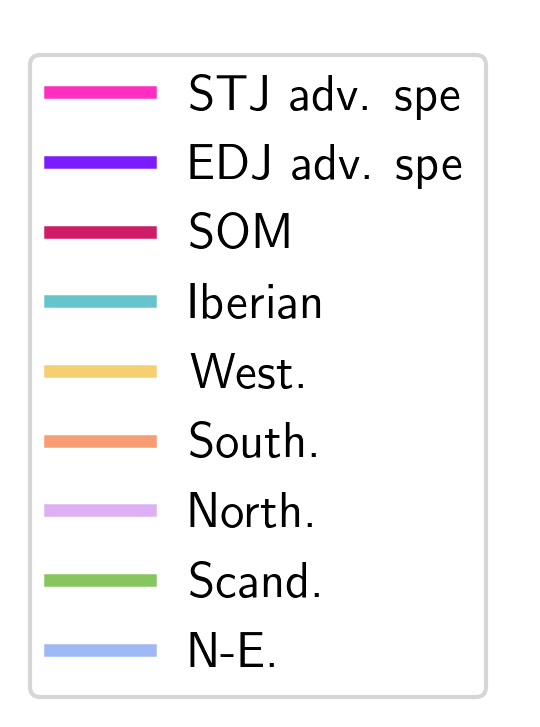

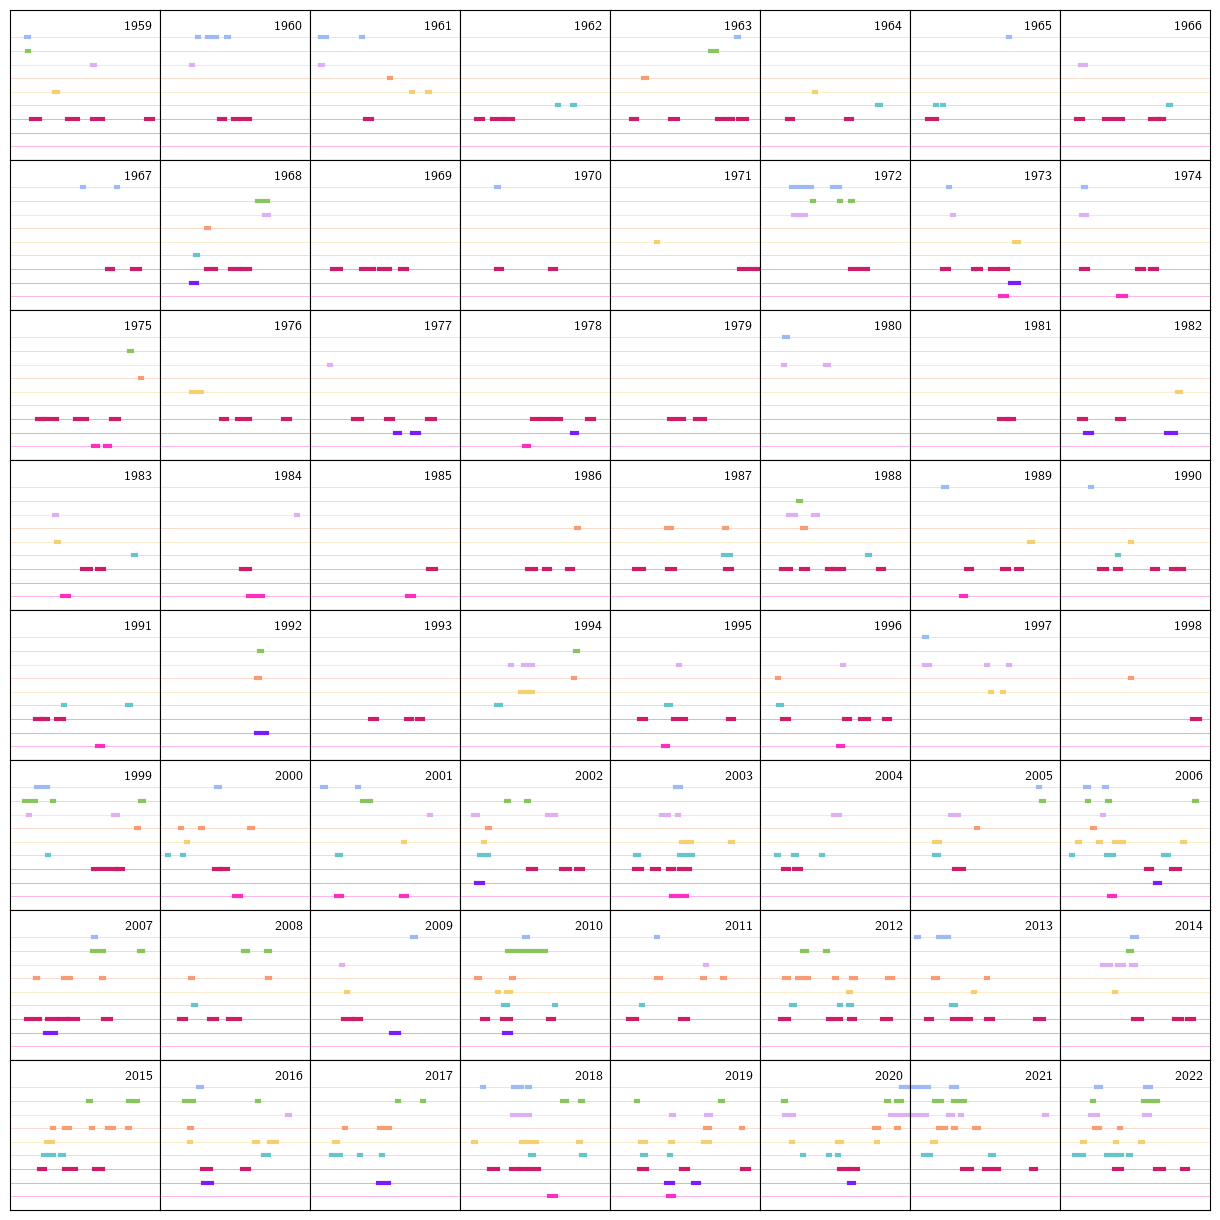

In [55]:
colors = [COLORS[2], COLORS[1], COLORS[3], *colormaps.pastel(np.linspace(0, 1, colormaps.pastel.N))[:6]]
for spell in spells_list.values():
    print(spell["spell"].max())
fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
ax.axis("off")
for spell_name, color in zip(spells_list, colors):
    ax.plot([], [], color=color, lw=3, label=spell_name)
ax.legend()
plt.show()
min_summer, max_summer =  summer.dt.ordinal_day().unique().first(),  summer.dt.ordinal_day().unique().last()
fig, axes = plt.subplots(
    8,
    8,
    figsize=(12, 12),
    gridspec_kw=dict(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1),
    subplot_kw=dict(xticks=[], yticks=[], xlim=[-1, max_summer - min_summer], ylim=[-1, 10]),
)
axes = axes.ravel()
for ax, year in zip(axes, YEARS):
    ax.text(110, len(spells_list) - 0.5, f"{year}", fontsize=10)
    for j, (name_, spell) in enumerate(spells_list.items()):
        ax.plot([-1, max_summer - min_summer], [j, j], color=colors[j], lw=0.5, ls="solid", alpha=0.5)
        spell_ = spell.filter(pl.col("time").dt.year() == year)
        if len(spell_) == 0:
            continue
        for s, indiv_spell in spell_.group_by("spell"):
            x = [
                indiv_spell["time"].dt.ordinal_day().first() - min_summer,
                indiv_spell["time"].dt.ordinal_day().last() - min_summer,
            ]
            y = [j, j]
            ax.plot(x, y, color=colors[j], lw=3)

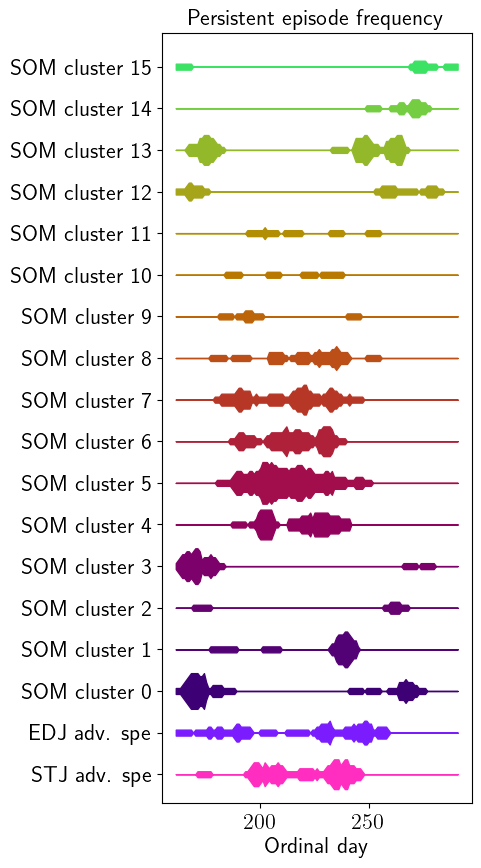

In [56]:
fig, ax = plt.subplots(figsize=(4, 10))
pe_colors = [COLORS[2], COLORS[1], *colormaps.chroma(np.linspace(0.2, 0.8, net.n_nodes))]
keys = [
    key for key in spells_list_extended if key not in [*DUNCANS_REGIONS_NAMES, "abs", "SOM"]
]
dy = 0.07
spells_list_reduced = [
    spells_list_extended[key][["spell", "time"]]
    .with_columns(type=pl.lit(key))
    .cast({"time": pl.Datetime("ms")})
    for key in keys
]
counts = (
    pl.concat(spells_list_reduced)
    .group_by(
        pl.col("time").dt.ordinal_day().alias("dayofyear"),
        pl.col("type"),
        maintain_order=True,
    )
    .len()
)
counts = (
    counts[["dayofyear"]]
    .unique("dayofyear")
    .join(counts[["type"]].unique("type"), how="cross")
    .join(counts, how="left", on=["dayofyear", "type"])
    .fill_null(0)
)
counts = counts.with_columns(prop=pl.col("len").over("type") / 200)
for i, key in enumerate(keys):
    if key == "SOM":
        continue
    subdf = counts.filter(pl.col("type") == key)
    subdf = subdf.sort("dayofyear")
    ax.fill_between(
        subdf["dayofyear"],
        i * dy + subdf["prop"],
        i * dy - subdf["prop"],
        color=pe_colors[i % len(pe_colors)],
    )
ax.set_ylim([-dy * 0.7, (i + 0.8) * dy])
ax.set_xlabel("Ordinal day")
ax.set_yticks(dy * np.arange(len(keys)), labels=keys)
ax.set_title("Persistent episode frequency")
plt.savefig(f"{FIGURES}/jet_persistence/occurence_frequency.png")

In [57]:
if "SOM" in spells_list_extended:
    del spells_list_extended["SOM"]
if "abs" in spells_list_extended:
    del spells_list_extended["abs"]
overlaps = np.zeros((len(spells_list_extended), len(spells_list_extended)))
for i, val1 in enumerate(spells_list_extended.values()):
    for j, val2 in enumerate(spells_list_extended.values()):
        overlaps[i, j] = (
            val1["time"]
            .cast(pl.Datetime("ms"))
            .is_in(val2["time"].cast(pl.Datetime("ms")))
            .mean()
        )

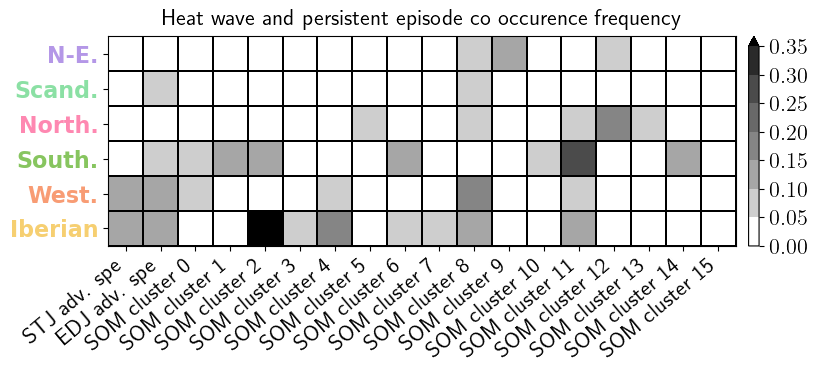

In [58]:
plt.style.use("default")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("axes", titlesize=16)
plt.rc("font", size=16)
plt.rc("text", usetex=True)
plt.rc("savefig", dpi=300)

fig, ax = plt.subplots(figsize=(10, 4), tight_layout=False)
levels = np.arange(0, 0.36, 0.05)
cmap = colormaps.grayc_r
cmap = make_transparent(cmap, len(levels), 1)
norm = BoundaryNorm(levels, cmap.N, extend="max")
im = ax.pcolormesh(
    overlaps[:-6, -6:].T, cmap=cmap, norm=norm, lw=0.1, ls="solid", edgecolor="black"
)
ylabel_colors = colormaps.pastel(np.linspace(0.1, 0.9, 6))
fig.colorbar(im, ax=ax, fraction=0.25, shrink=1, pad=0.015)
ax.set_title("Heat wave and persistent episode co occurence frequency", pad=8)
ax.set_yticks(
    np.arange(6) + 0.5, list(spells_list_extended)[-6:], ha="right", rotation=0
)
for color, ticklabel, tick in zip(
    ylabel_colors, ax.yaxis.get_ticklabels(), ax.yaxis.get_ticklines()
):
    ticklabel.set_color(color)
    ticklabel.set_weight("demi")
    ticklabel.set_usetex(False)
    tick.set_color(color)
ax.set_xticks(
    np.arange(len(spells_list_extended) - 6) + 0.5,
    list(spells_list_extended)[:-6],
    rotation=40,
    ha="right",
)
# for color, ticklabel, tick in zip(
#     pe_colors, ax.xaxis.get_ticklabels(), ax.xaxis.get_ticklines()
# ):
#     ticklabel.set_color(color)
#     ticklabel.set_weight("demi")
#     ticklabel.set_usetex(False)
#     tick.set_color(color)
plt.savefig(f"{FIGURES}/twostep_persistence/heat_waves_co_occurence.png")

# Compare with CDSK and abs spe

In [26]:
import CDSK

da_ = coarsen_da(ds["s"], 6, np.amax)
da_anom = compute_anomalies_ds(da_, "dayofyear", standardized=True)

In [ ]:
X = da_.values.reshape(da_.shape[0], -1)
a, b, c = CDSK.dynamical_local_indexes(X, n_jobs=N_WORKERS)
dim = a[:, 0, 0]
theta = b[:, 0, 0]
dim_pd = pl.DataFrame({"time": da_.time.values, "dim": dim})
theta_pd = pl.DataFrame({"time": da_.time.values, "theta": theta})

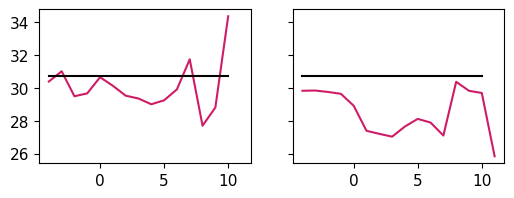

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2), sharex="all", sharey="all")
axes = axes.ravel()
for jet, ax in zip(["STJ", "EDJ"], axes):
    ax.plot(*mask_from_spells_pl(spells_list_extended[f"{jet} adv. spe"], dim_pd, time_before=datetime.timedelta(days=4)).group_by("relative_index").mean().sort("relative_index")[["relative_index", "dim"]].to_numpy().T, color=COLORS[3])
    ax.plot([-4, 10], [dim_pd["dim"].mean()] * 2, color="black")

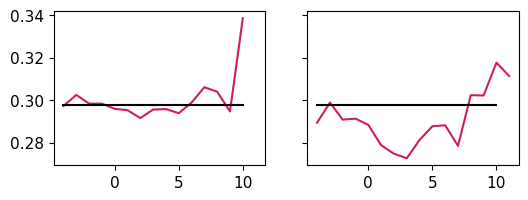

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2), sharex="all", sharey="all")
axes = axes.ravel()
for jet, ax in zip(["STJ", "EDJ"], axes):
    ax.plot(*mask_from_spells_pl(spells_list_extended[f"{jet} adv. spe"], theta_pd, time_before=datetime.timedelta(days=4)).group_by("relative_index").mean().sort("relative_index")[["relative_index", "theta"]].to_numpy().T, color=COLORS[3])
    ax.plot([-4, 10], [theta_pd["theta"].mean()] * 2, color="black")

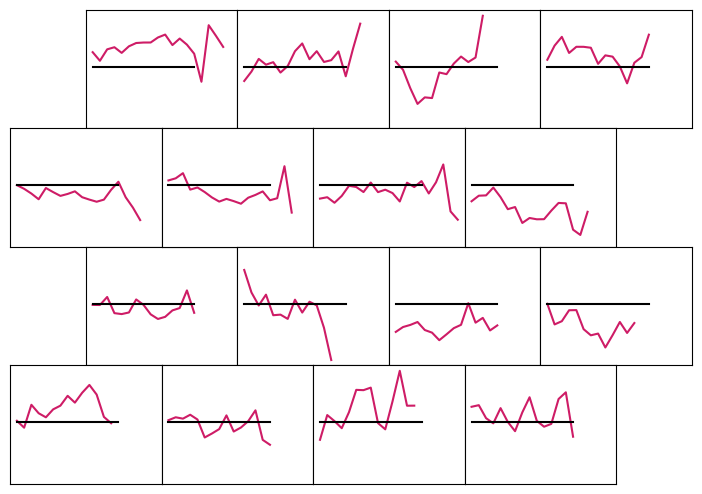

In [96]:
fig, axes = honeycomb_panel(4, 4, ratio=0.7, row_height=2.2)
axes = axes.ravel()
for ax in axes[1:]:
    ax.sharex(axes[0])
    ax.sharey(axes[0])
    ax.set_xticks([])
    ax.set_yticks([])
for i, ax in enumerate(axes):
    ax.plot(*mask_from_spells_pl(spells_list_extended[f"SOM cluster {i}"], dim_pd, time_before=datetime.timedelta(days=4)).group_by("relative_index").mean().sort("relative_index")[["relative_index", "dim"]].to_numpy().T, color=COLORS[3])
    ax.plot([-4, 10], [dim_pd["dim"].mean()] * 2, color="black")

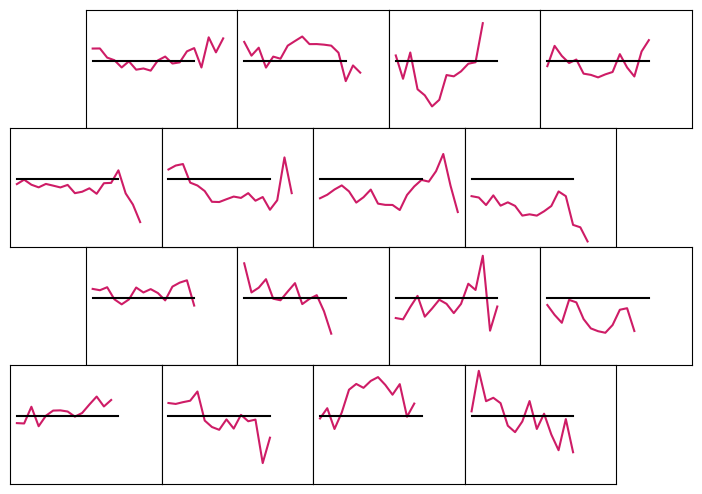

In [ ]:
fig, axes = honeycomb_panel(4, 4, ratio=0.7, row_height=2.2)
axes = axes.ravel()
for ax in axes[1:]:
    ax.sharex(axes[0])
    ax.sharey(axes[0])
    ax.set_xticks([])
    ax.set_yticks([])
for i, ax in enumerate(axes):
    ax.plot(*mask_from_spells_pl(spells_list_extended[f"SOM cluster {i}"], theta_pd, time_before=datetime.timedelta(days=4)).group_by("relative_index").mean().sort("relative_index")[["relative_index", "theta"]].to_numpy().T, color=COLORS[3])
    ax.plot([-4, 10], [theta_pd["theta"].mean()] * 2, color="black")

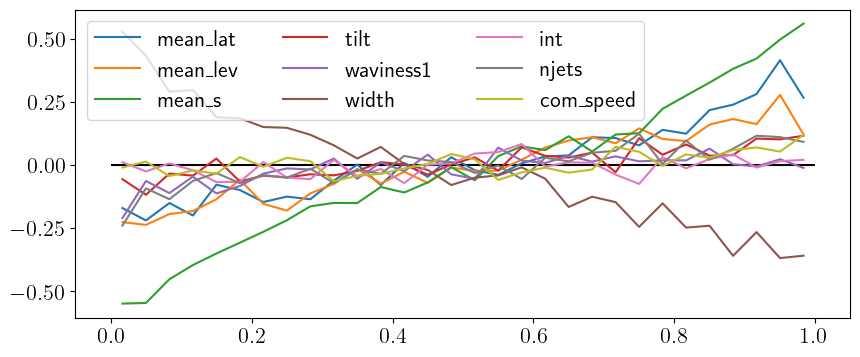

In [59]:
from itertools import pairwise
n_q = 31
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "tilt",
    "waviness1",
    "width",
    "int",
    "njets",
    "com_speed",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
spe = speed_realspace["speed"].to_numpy()
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = (spe < np.quantile(spe, q2)) & (spe >= np.quantile(spe, q1))
    props = props_as_df_anoms.filter(pl.col("jet") == "EDJ")[np.where(filter_)[0]].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
ax.hlines(0, 1, 0, colors="black")
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

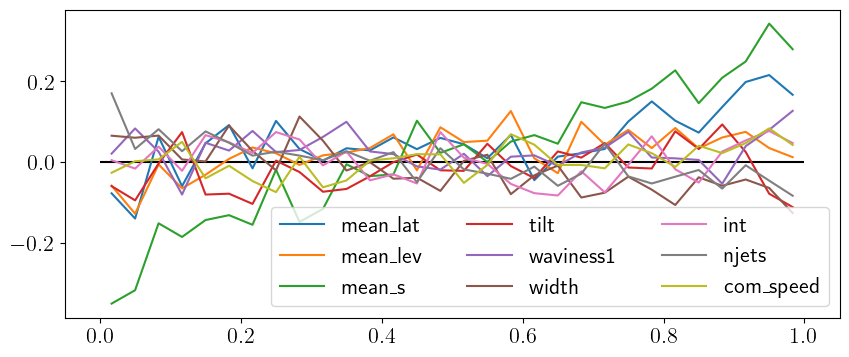

In [60]:
from itertools import pairwise
n_q = 31
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "tilt",
    "waviness1",
    "width",
    "int",
    "njets",
    "com_speed",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
spe = speed_realspace["speed"].to_numpy()
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = (spe < np.quantile(spe, q2)) & (spe >= np.quantile(spe, q1))
    props = props_as_df_anoms.filter(pl.col("jet") == "STJ")[np.where(filter_)[0]].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
ax.hlines(0, 1, 0, colors="black")
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

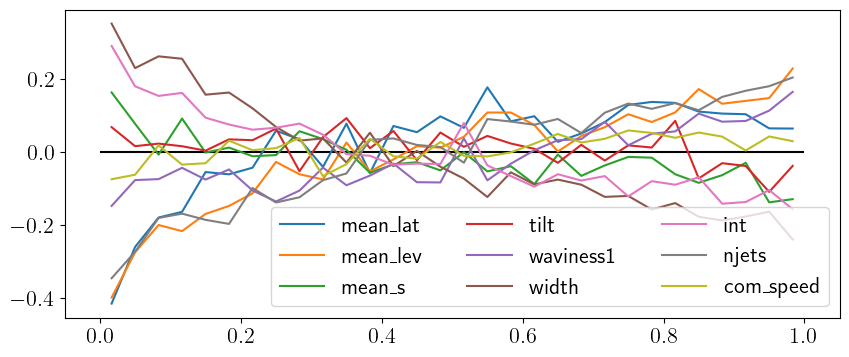

In [61]:
from itertools import pairwise
n_q = 31
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "tilt",
    "waviness1",
    "width",
    "int",
    "njets",
    "com_speed",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = (theta < np.quantile(theta, q2)) & (theta >= np.quantile(theta, q1))
    props = props_as_df_anoms.filter(pl.col("jet") == "EDJ")[np.where(filter_)[0]].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
ax.hlines(0, 1, 0, colors="black")
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

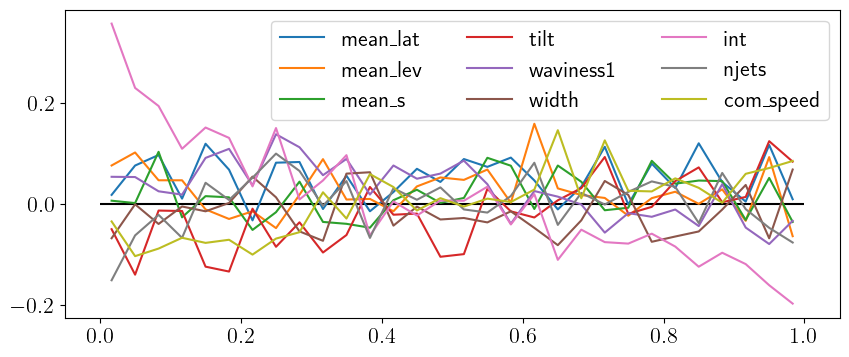

In [62]:
from itertools import pairwise
n_q = 31
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "tilt",
    "waviness1",
    "width",
    "int",
    "njets",
    "com_speed",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = (theta < np.quantile(theta, q2)) & (theta >= np.quantile(theta, q1))
    props = props_as_df_anoms.filter(pl.col("jet") == "STJ")[np.where(filter_)[0]].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
ax.hlines(0, 1, 0, colors="black")
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

# Natural coordinates composites

In [59]:
def symmetrize_p(
    pvals: xr.DataArray | np.ndarray, direction: int, q: float
) -> np.ndarray:
    if direction == 0:
        return np.amin([pvals * 2, (1 - pvals) * 2], axis=0) < q
    if direction == 1:
        return np.asarray(pvals) > 1 - q
    return np.asarray(pvals) < q


def plot_all_relative_composites(jets, times, variable_dict, n_bootstraps: int = 50):
    figs = []
    for varname, props in variable_dict.items():
        if len(props) == 3:
            da, nlevels, cmap = props
            clim = None
        else:
            da, clim, nlevels, cmap = props
        hatch = "xxx" if varname == "tp" else "xx"

        jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(
            jets, times, da, n_bootstraps=n_bootstraps, clim=clim
        )
        try:
            to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
            pvals = jets_during_spells_with_interp_norm_ds["pvals"]
        except KeyError:
            to_plot = jets_during_spells_with_interp_norm_ds

        direction = infer_direction(to_plot)
        symmetric = direction == 0

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(
            to_plot.quantile(0.01), to_plot.quantile(0.99)
        )
        norm = BoundaryNorm(levels, cmap.N)

        axes[0].pcolormesh(
            to_plot.norm_index, to_plot.n, to_plot[0].T, norm=norm, cmap=cmap
        )
        filter_ = symmetrize_p(pvals[0].T, direction, 0.05)
        axes[0].pcolor(
            pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.0
        )

        axes[1].pcolormesh(
            to_plot.norm_index, to_plot.n, to_plot[1].T, norm=norm, cmap=cmap
        )
        filter_ = symmetrize_p(pvals[1].T, direction, 0.05)
        axes[1].pcolor(
            pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.0
        )

        fig.colorbar(ScalarMappable(norm, cmap), ax=axes, spacing="proportional")
        figs.append(fig)
    return figs


# clim_T = xr.open_dataarray(exp.path.joinpath("t2m_relative_clim.nc"))
# clim_tp = xr.open_dataarray(exp.path.joinpath("tp_relative_clim.nc"))
# clim_apvs = xr.open_dataarray(exp.path.joinpath("apvs_relative_clim.nc"))
# clim_cpvs = xr.open_dataarray(exp.path.joinpath("cpvs_relative_clim.nc"))
# clim_sst = xr.open_dataarray(exp.path.joinpath("sst_relative_clim.nc"))

# variable_dict = {
#     "t2m": [da_T, clim_T, 8, colormaps.BlWhRe],
#     "tp": [da_tp, clim_tp, 15, colormaps.precip4_diff_19lev],
#     "APVS": [da_apvs, clim_apvs, 7, colormaps.curl],
#     "CPVS": [da_cpvs, clim_cpvs, 7, colormaps.curl],
#     "sst": [da_sst, clim_sst, 7, colormaps.BlWhRe]
# }
variable_dict = {
    # "t2m": [da_T, 8, colormaps.BlWhRe],
    "t_up": [da_T_upper_anom, 8, colormaps.BlWhRe, [-4, 4]],
    "tp": [da_tp * 1000, 15, colormaps.precip4_diff_19lev, [-2, 2]],
    "apvs": [da_apvs * 100, 7, colormaps.curl, [-30, 30]],
    "cpvs": [da_cpvs * 100, 7, colormaps.curl, [-30, 30]],
}
long_names = {
    "t_up": "Upper level temperature [K]",
    "t2m": "2m temperature [K]",
    "tp": "Daily accum. precip. [mm]",
    "apvs": r"Anticyclonic PV streamer freq [$\%$]",
    "cpvs": r"Cyclonic PV streamer freq [$\%$]",
}

## Mean anomaly at onset

KeyboardInterrupt: 

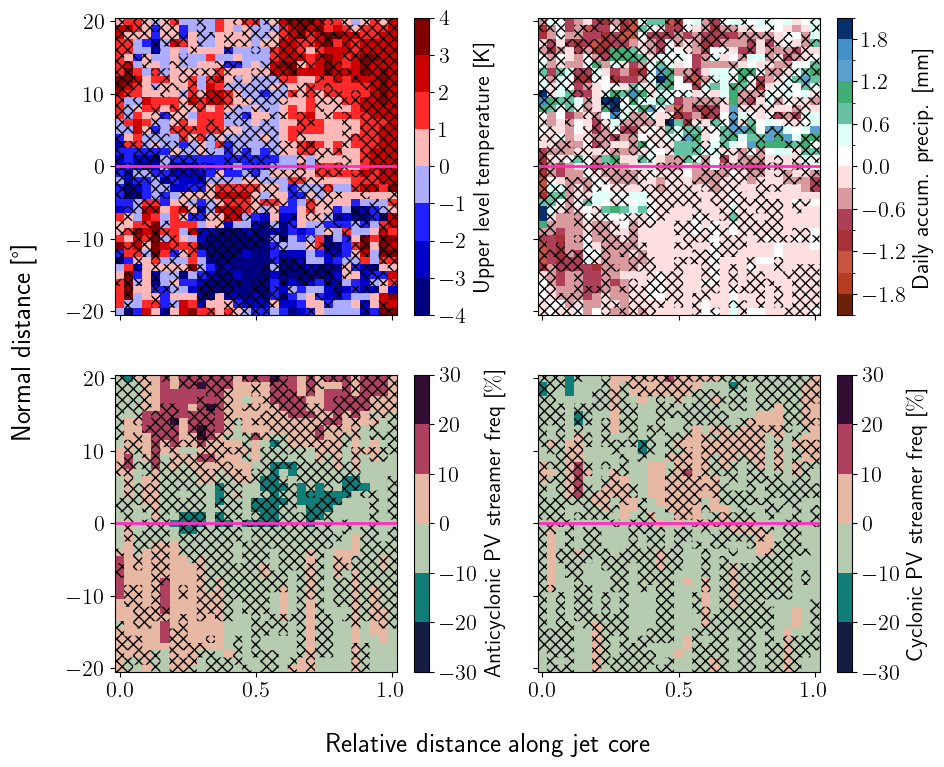

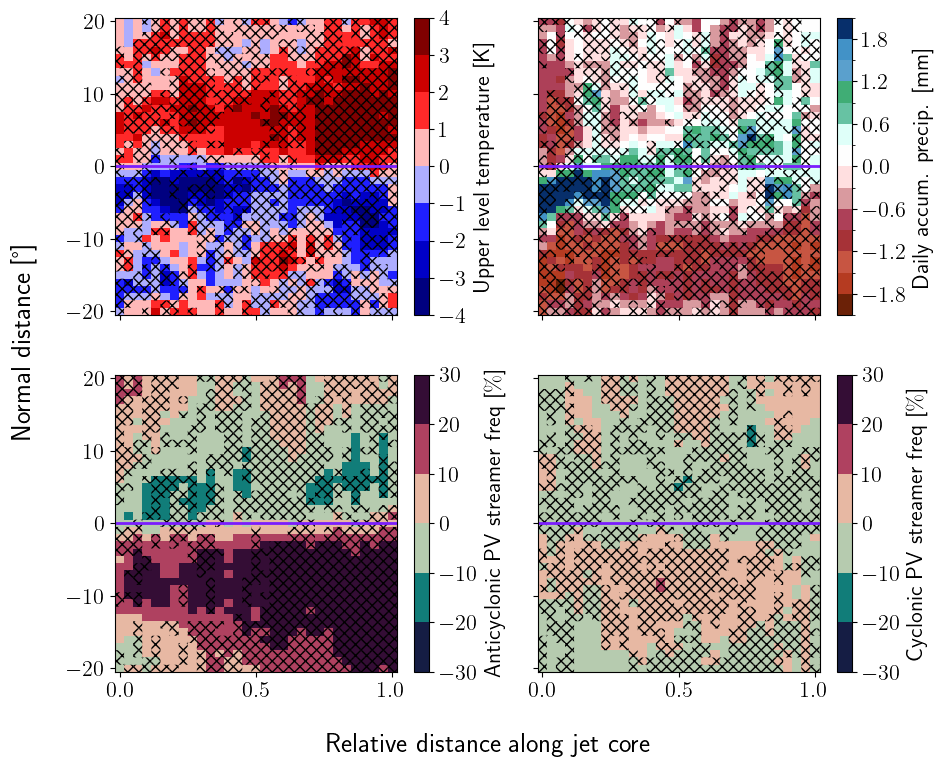

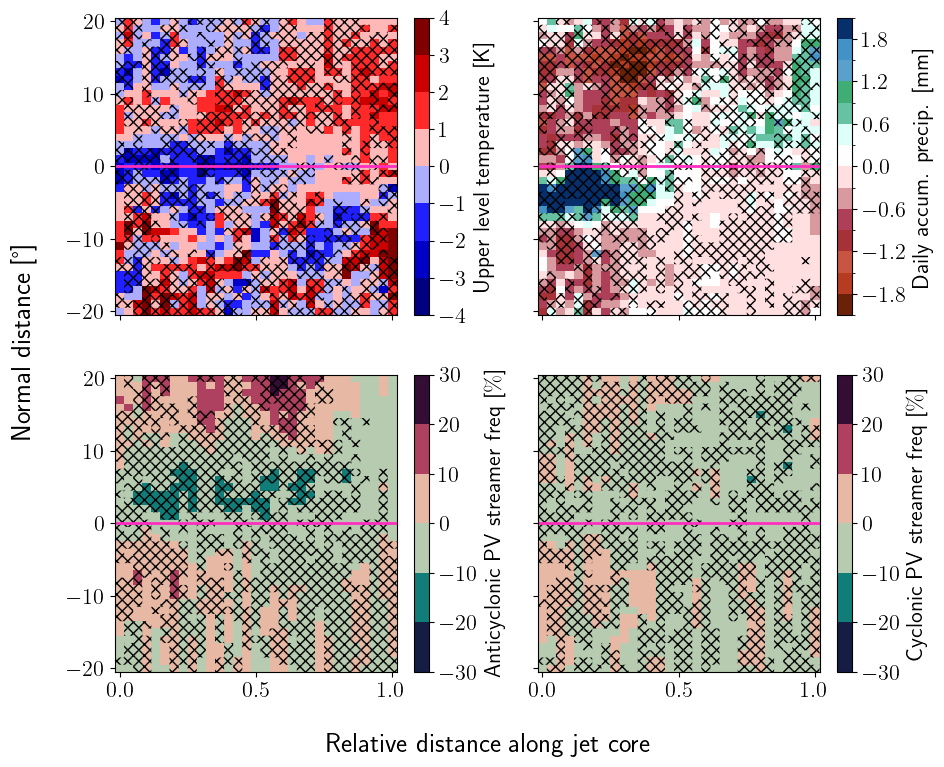

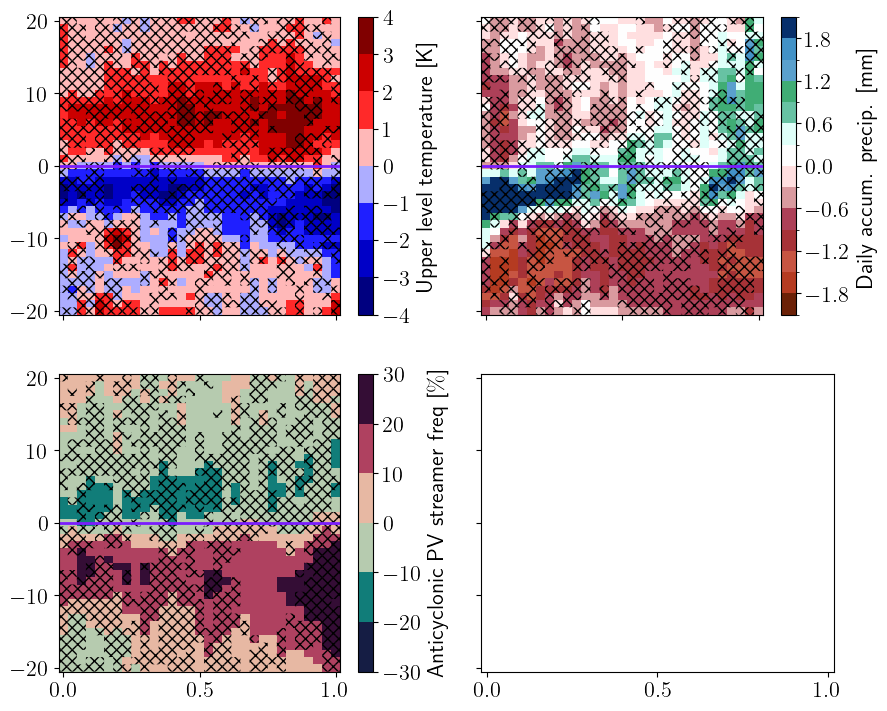

In [40]:
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("font", size=16)
plt.rc("savefig", dpi=300)
from itertools import product

n_bootstraps = 2
for spells_of in ["STJ", "EDJ"]:
    spells_from_jet = spells_list[f"{spells_of} adv. spe"]
    spells_from_jet = extend_spells(spells_from_jet)
    jets = summer_daily.rename("time").to_frame().join(all_jets_one_df, on="time")
    times = spells_from_jet
    figs = {}
    axess = {}
    for composites_around in ["STJ", "EDJ"]:
        fig, axes = plt.subplots(
            2, 2, figsize=(10, 8.5), sharex="all", sharey="all", gridspec_kw=dict(wspace=0.2)
        )
        axes = axes.ravel()
        figs[composites_around] = fig
        axess[composites_around] = axes
    for i, (varname, props) in enumerate(variable_dict.items()):
        da, nlevels, cmap, (min_, max_) = props
        clim = None
        hatch = "xxx"
        jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(
            jets.cast({"time": pl.Datetime("ms")}), times, da, n_bootstraps=n_bootstraps, clim=clim
        )
        try:
            to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
            pvals = jets_during_spells_with_interp_norm_ds["pvals"]
        except KeyError:
            to_plot = jets_during_spells_with_interp_norm_ds
        direction = infer_direction(to_plot)
        symmetric = direction == 0

        levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(
            min_, max_
        )
        norm = BoundaryNorm(levels, cmap.N)
        for j, composites_around in enumerate(["STJ", "EDJ"]):
            fig = figs[composites_around]
            ax = axess[composites_around][i]
            ax.pcolormesh(to_plot.norm_index, to_plot.n, to_plot[j].T, norm=norm, cmap=cmap)
            filter_ = symmetrize_p(pvals[j].T, direction, 0.1)
            ax.pcolor(
                pvals.norm_index, pvals.n, pvals[j].T.where(filter_), hatch=hatch, alpha=0.0
            )
            xlim = ax.get_xlim()
            ax.plot((-0.1, 1.1), (0, 0), lw=2, color=COLORS[2 - j])
            ax.set_xlim(xlim)
            cbar = fig.colorbar(ScalarMappable(norm, cmap), ax=ax, spacing="proportional")
            cbar.set_label(long_names[varname], fontsize=16)
            
            if i == 3:  
                fig.supylabel("Normal distance [°]")
                fig.supxlabel("Relative distance along jet core")
                plt.draw()
                fig.savefig(f"{FIGURES}/jet_persistence/{spells_of}_spells_{composites_around}_composites.png")

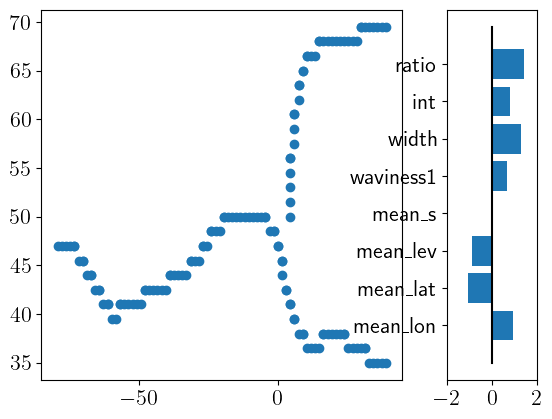

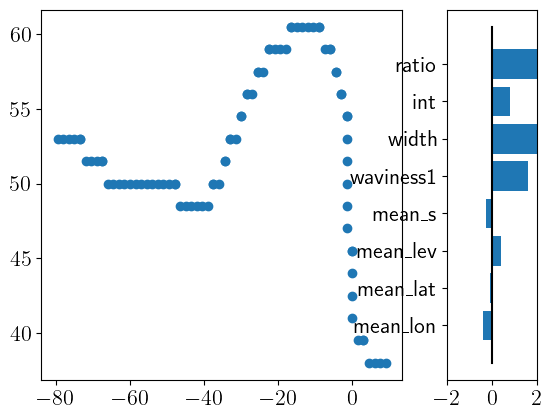

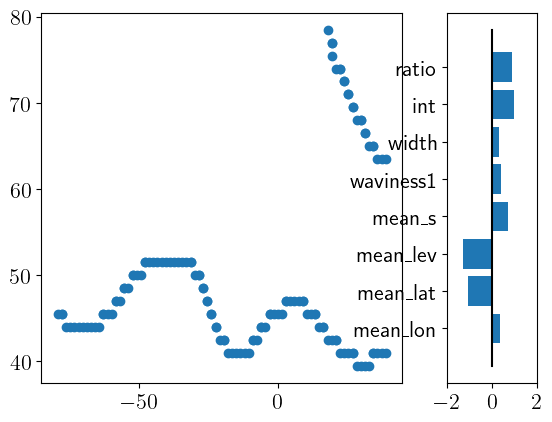

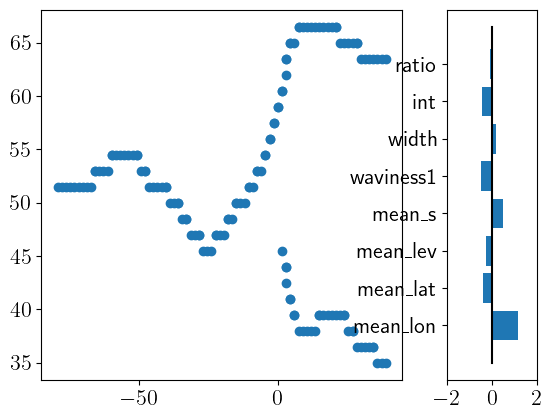

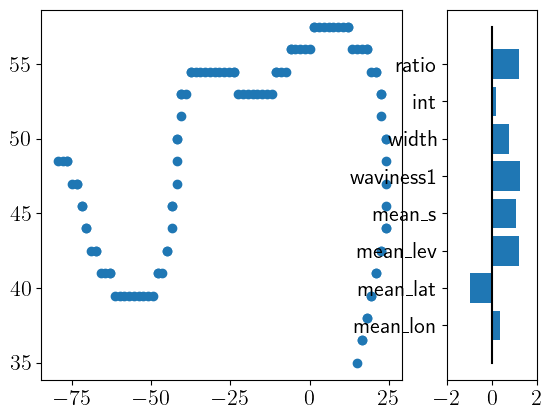

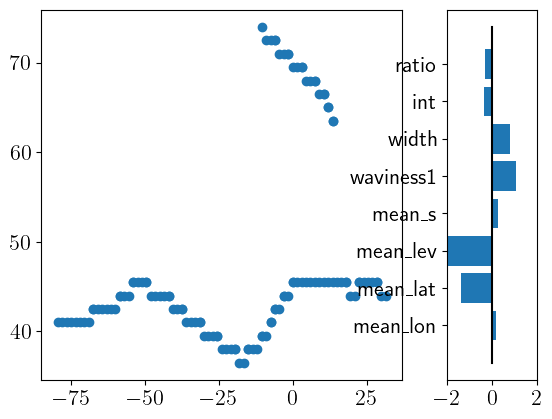

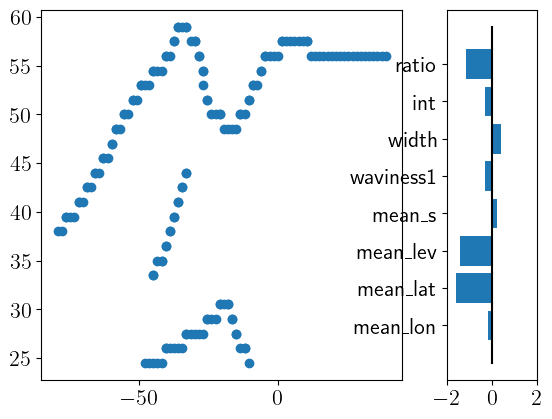

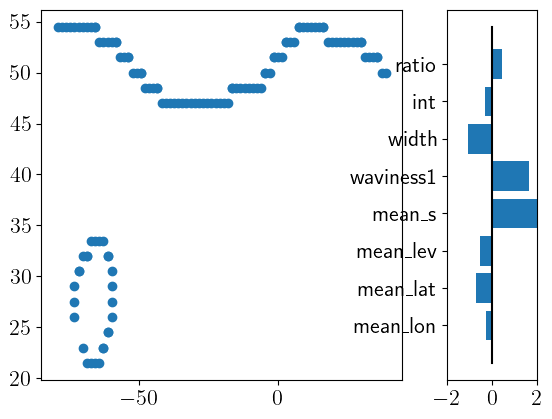

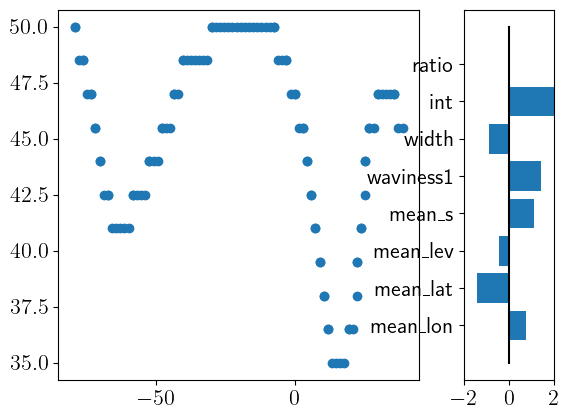

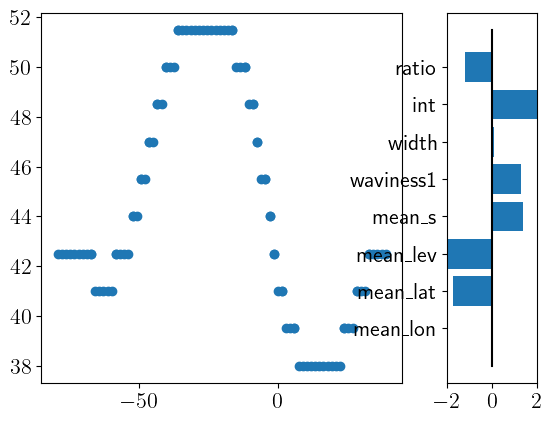

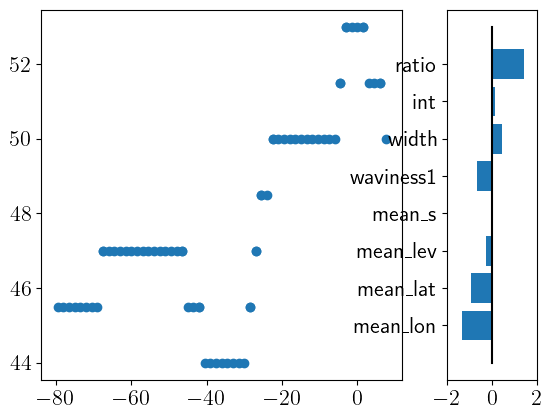

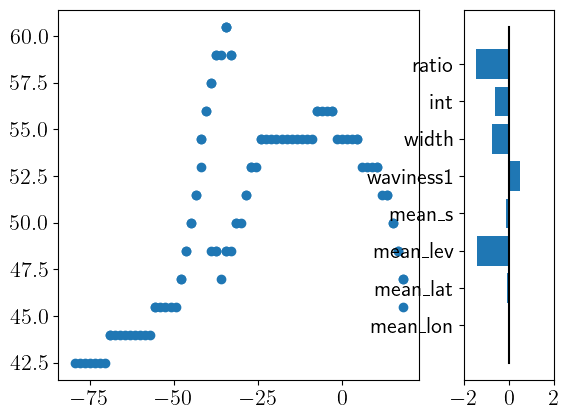

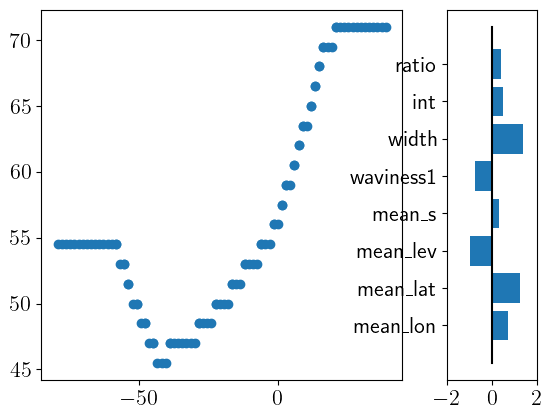

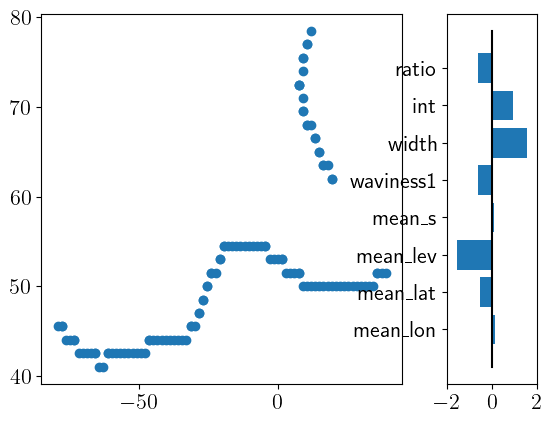

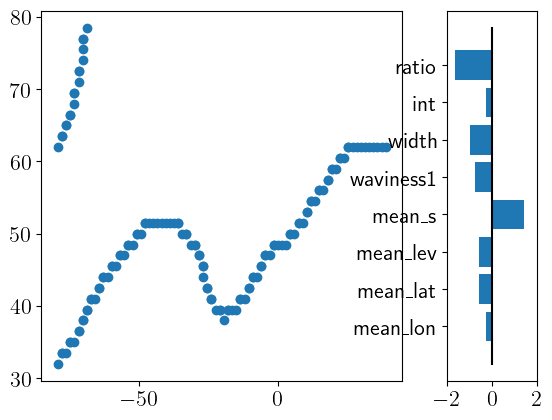

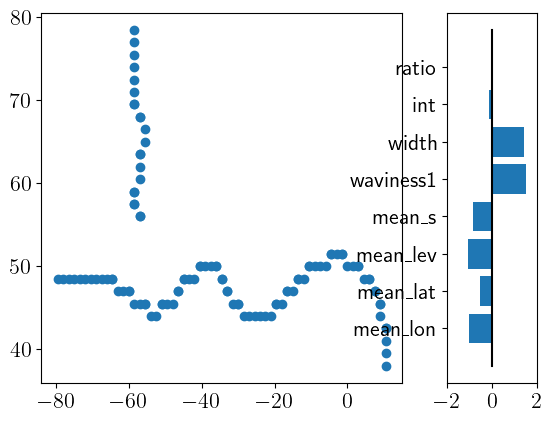

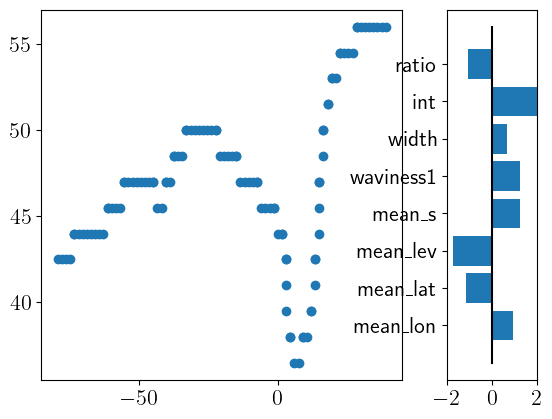

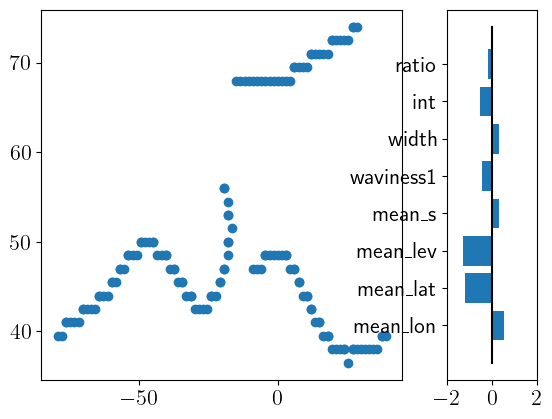

In [109]:
spells_of = "EDJ"
spells_from_jet = spells_list[f"{spells_of} adv. spe"]
n_spells = spells_from_jet["spell"].n_unique()
jets_daily = summer_daily.rename("time").to_frame().join(all_jets_one_df, on="time")
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "waviness1",
    "width",
    "int",
    "ratio",
]
for i in range(n_spells):
    spell_from_jet = spells_from_jet.filter(pl.col("spell") == i, pl.col("relative_index").is_in([0]))
    jets = jets_daily.filter(pl.col("time").is_in(spell_from_jet["time"]))
    EDJs = jets.filter(pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5)
    fig, (ax, ax2) = plt.subplots(1, 2, width_ratios=[0.8, 0.2])
    ax.scatter(*EDJs[["lon", "lat"]].to_numpy().T)
    these_props = props_as_df_anoms.filter(pl.col("time").is_in(spell_from_jet["time"]), pl.col("jet") == "EDJ")[data_vars]
    ax2.barh(np.arange(len(data_vars)), these_props.to_numpy().ravel())
    ax2.set_xlim([-2, 2])
    ax2.plot([0, 0], [-1, len(data_vars)], color="black")
    ax2.set_yticks(np.arange(len(data_vars)), labels=data_vars)

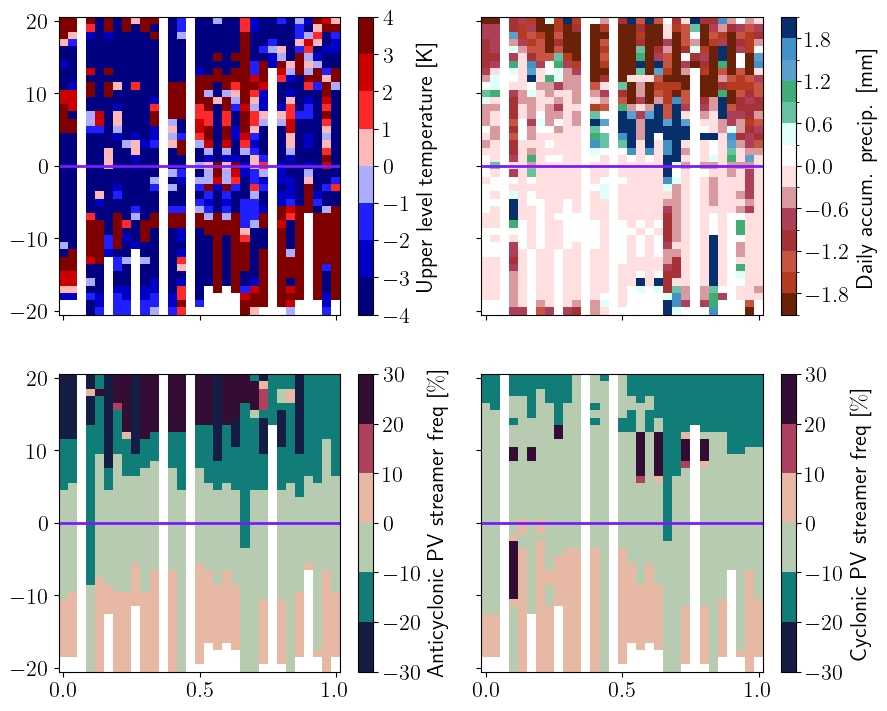

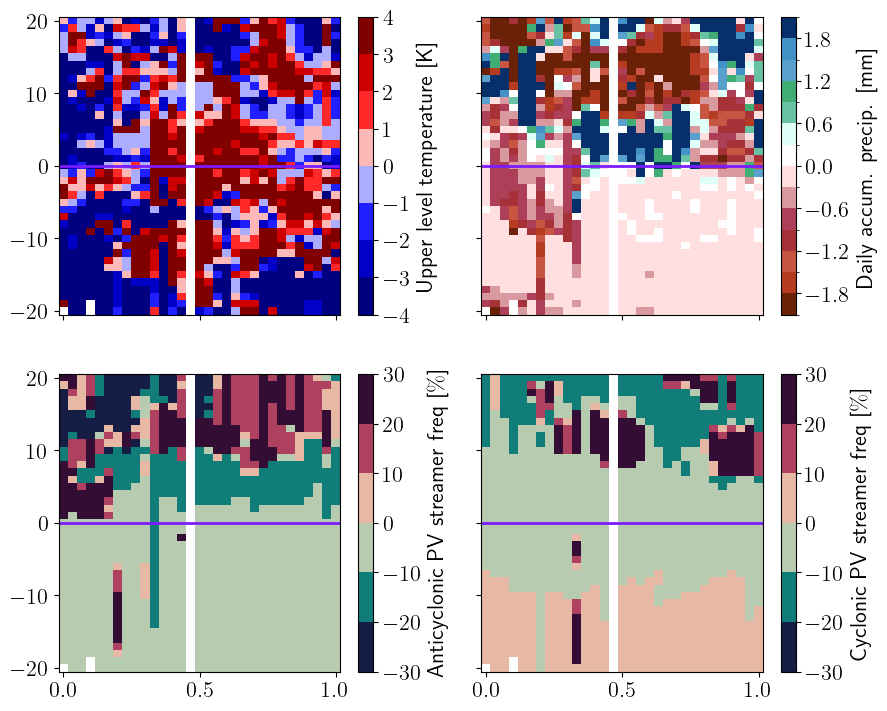

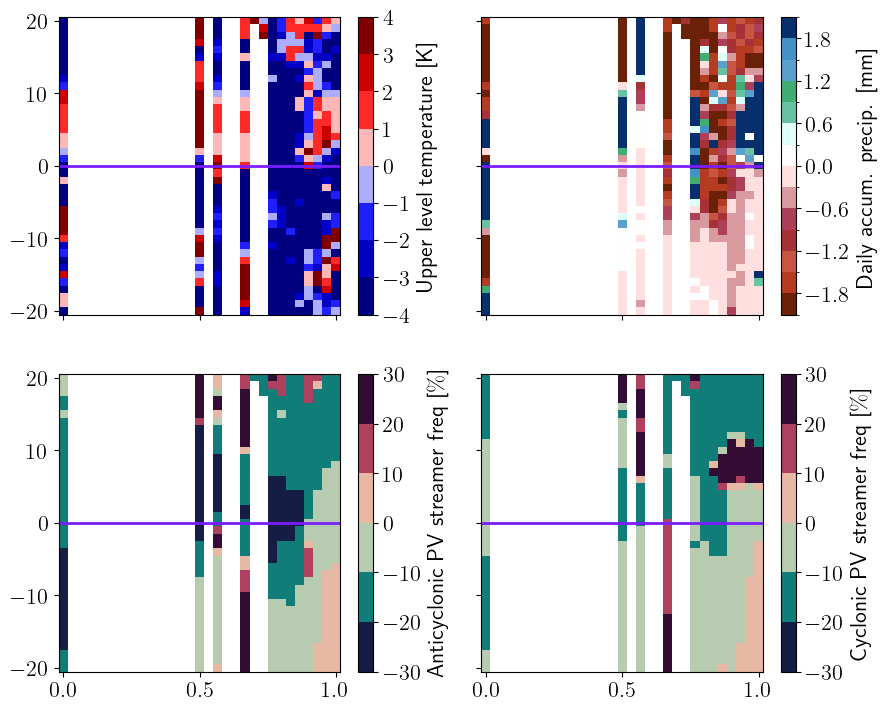

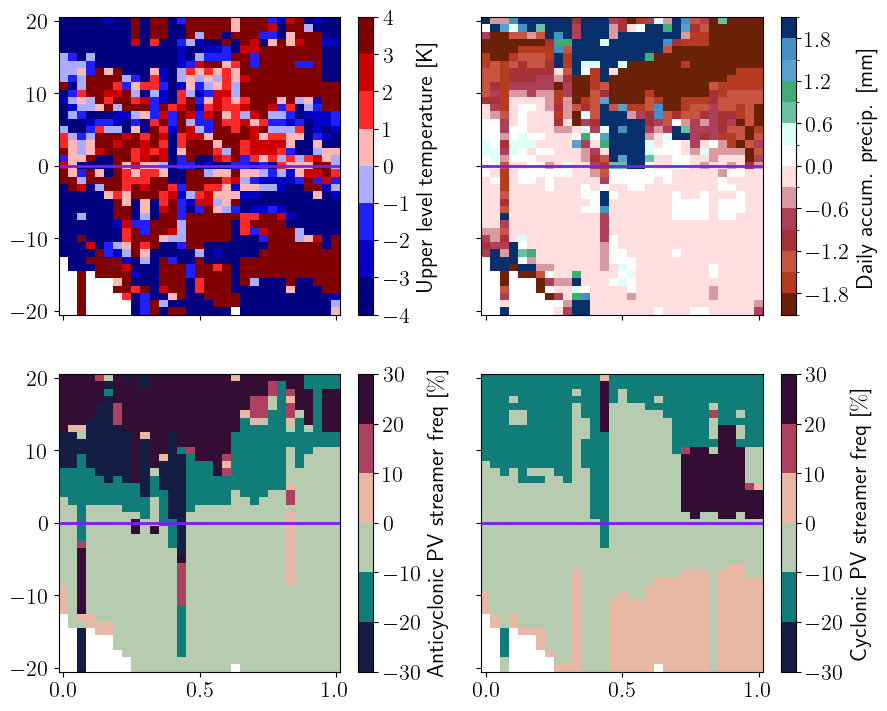

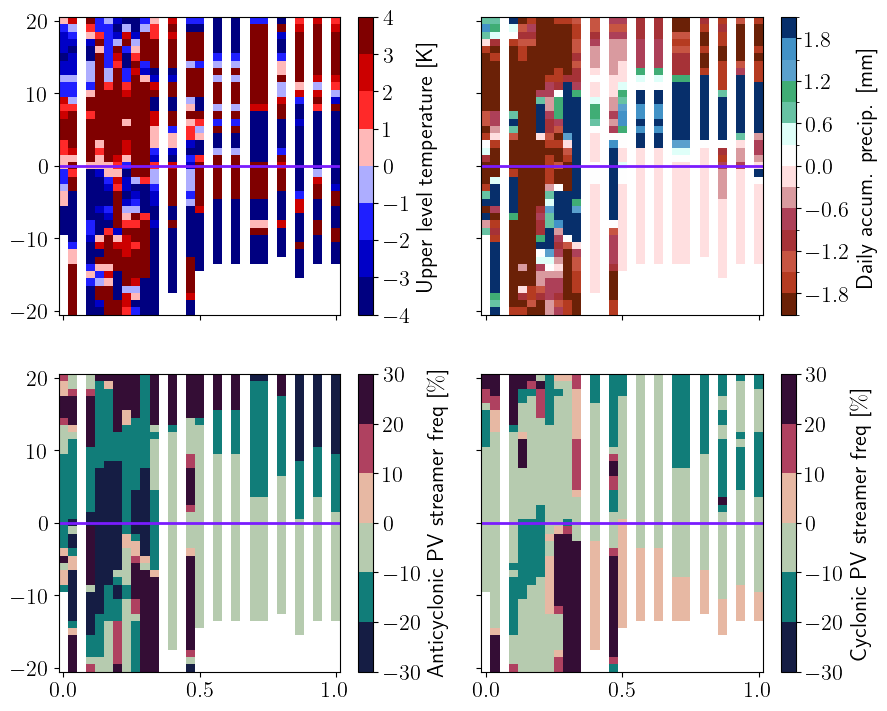

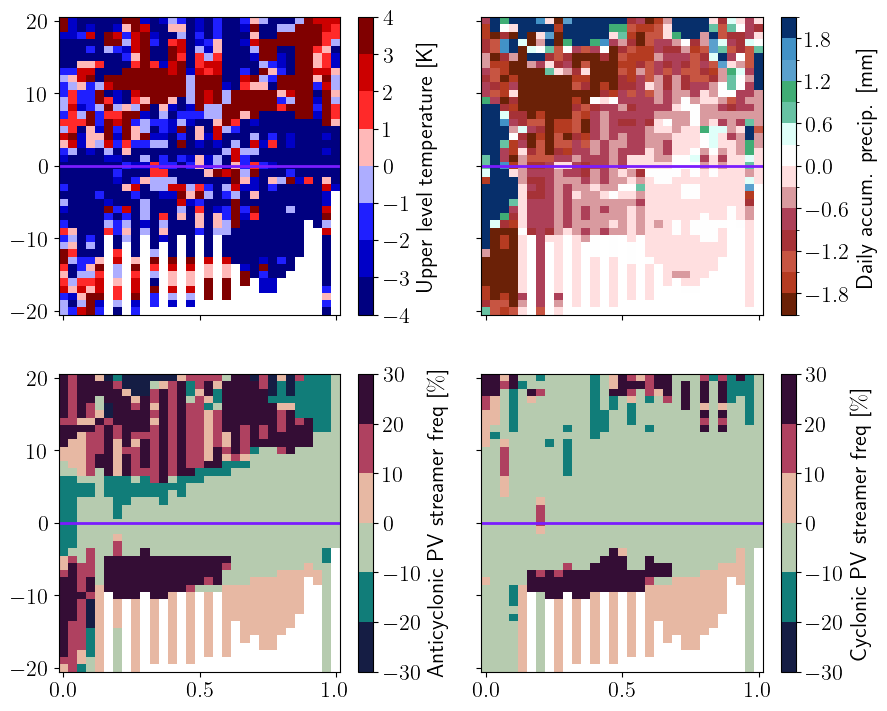

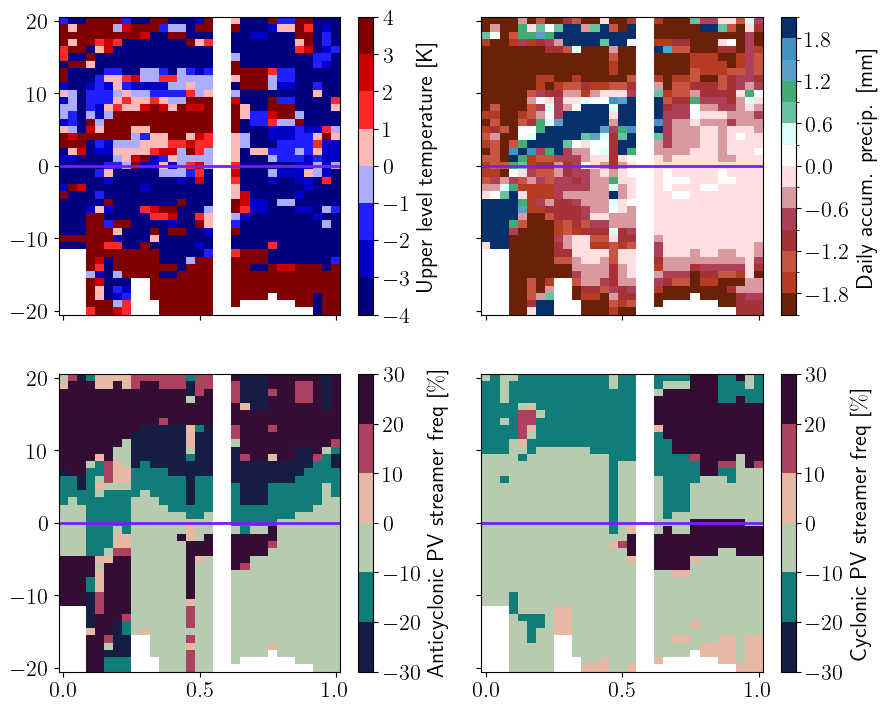

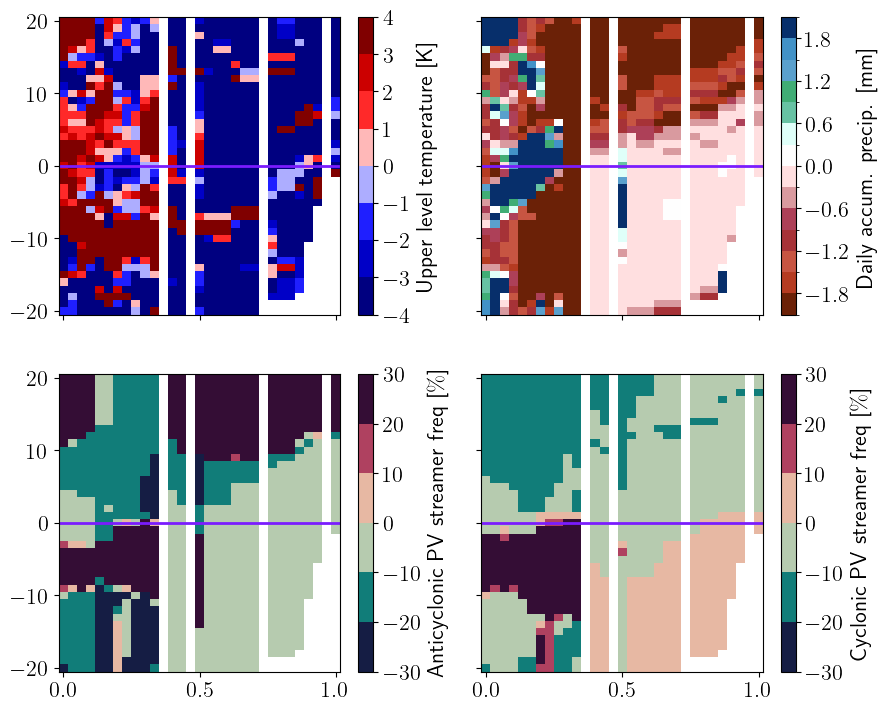

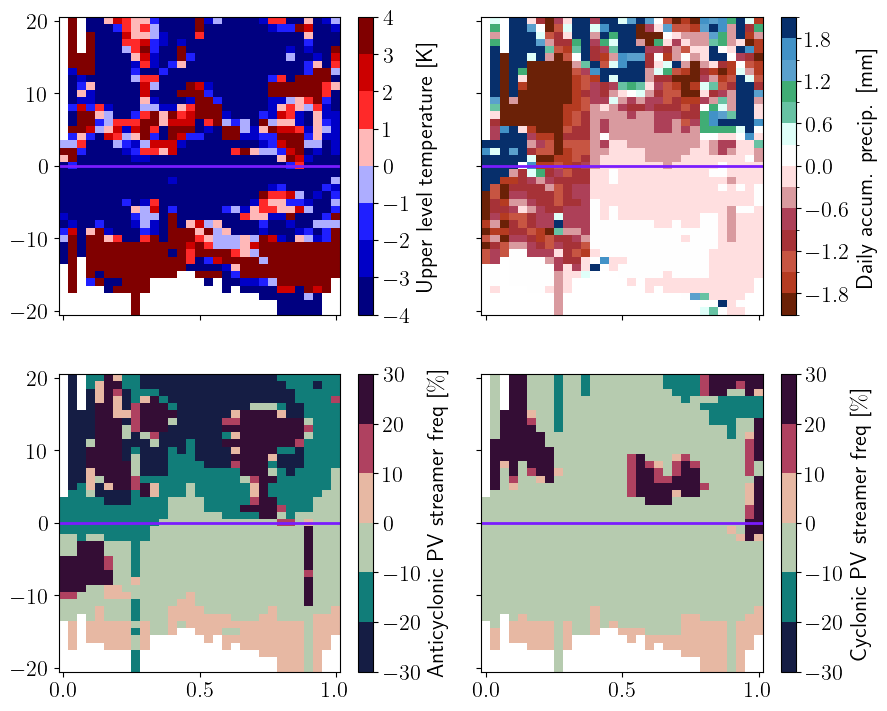

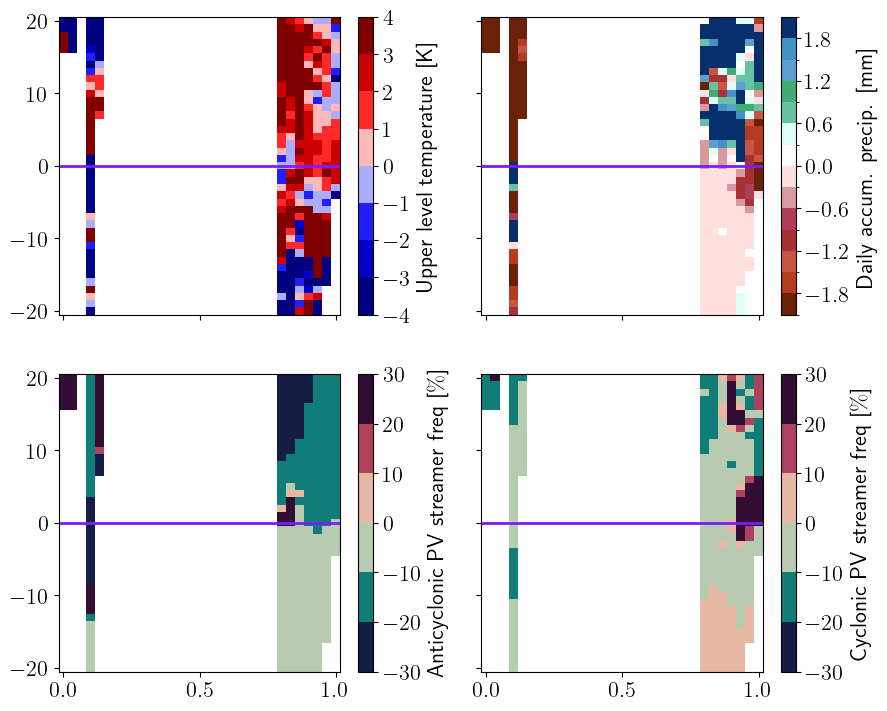

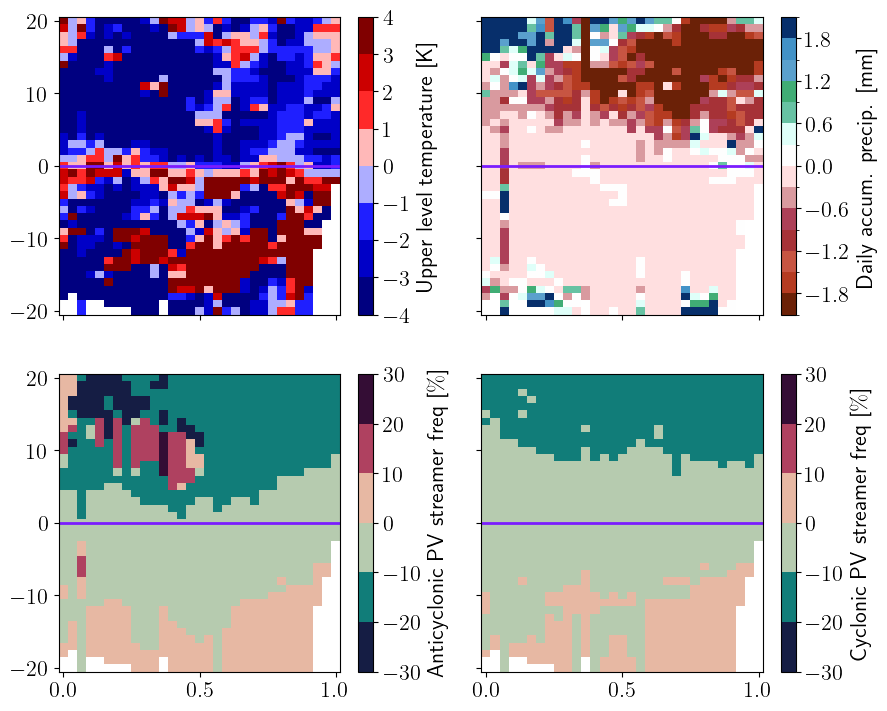

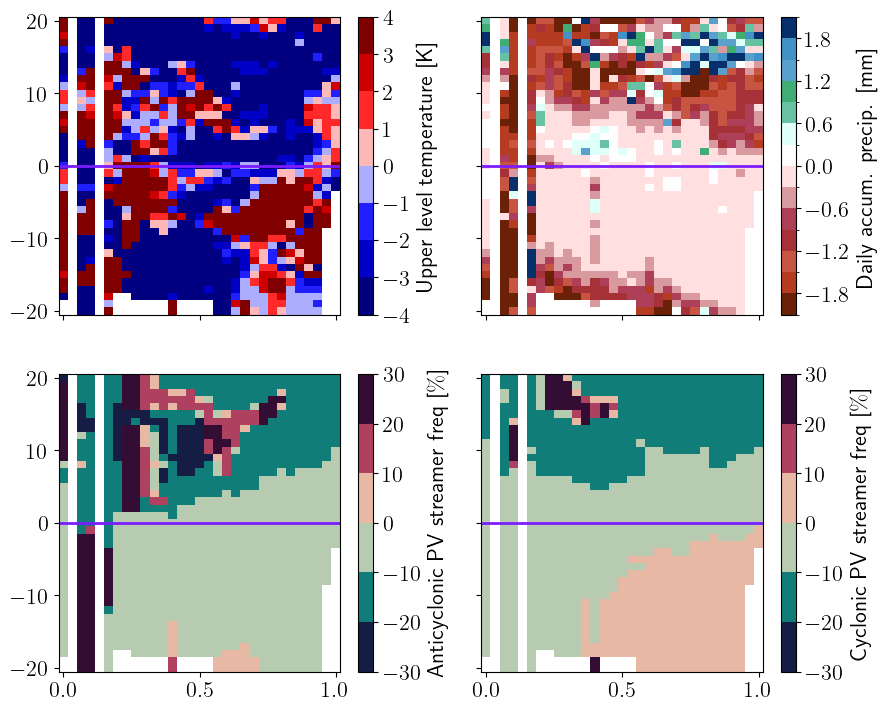

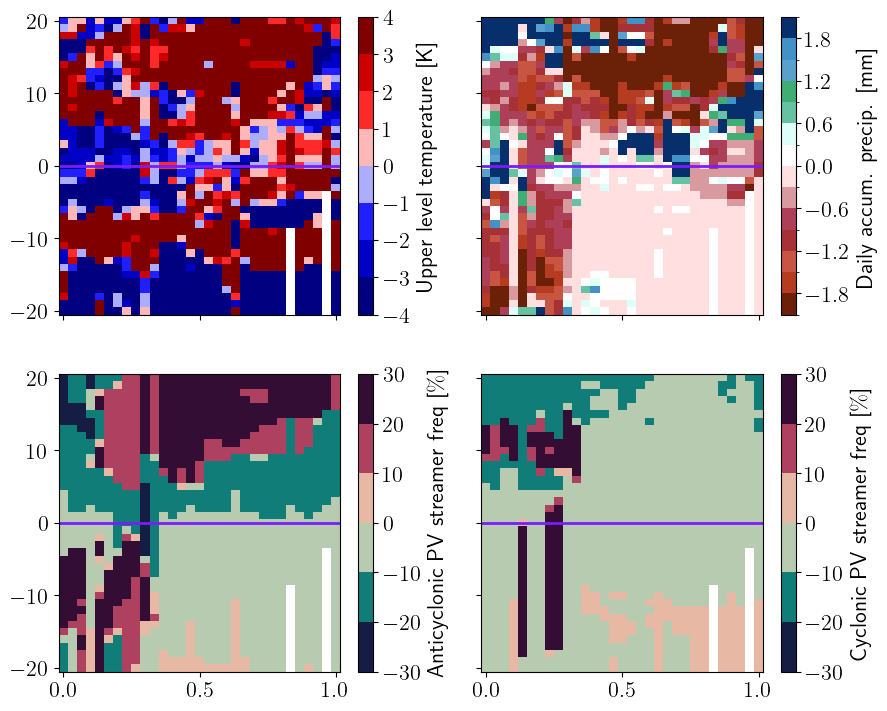

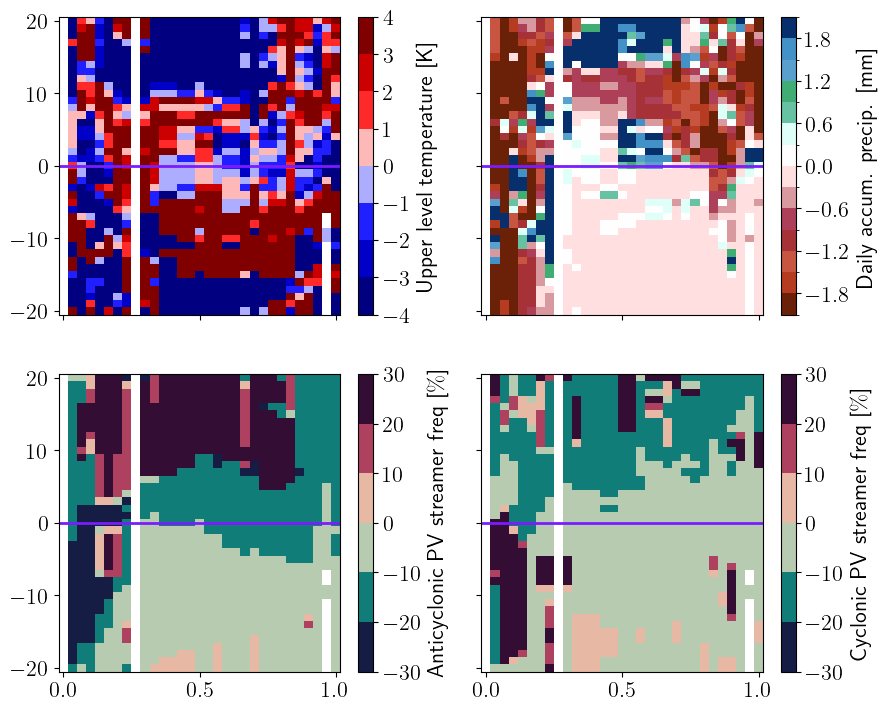

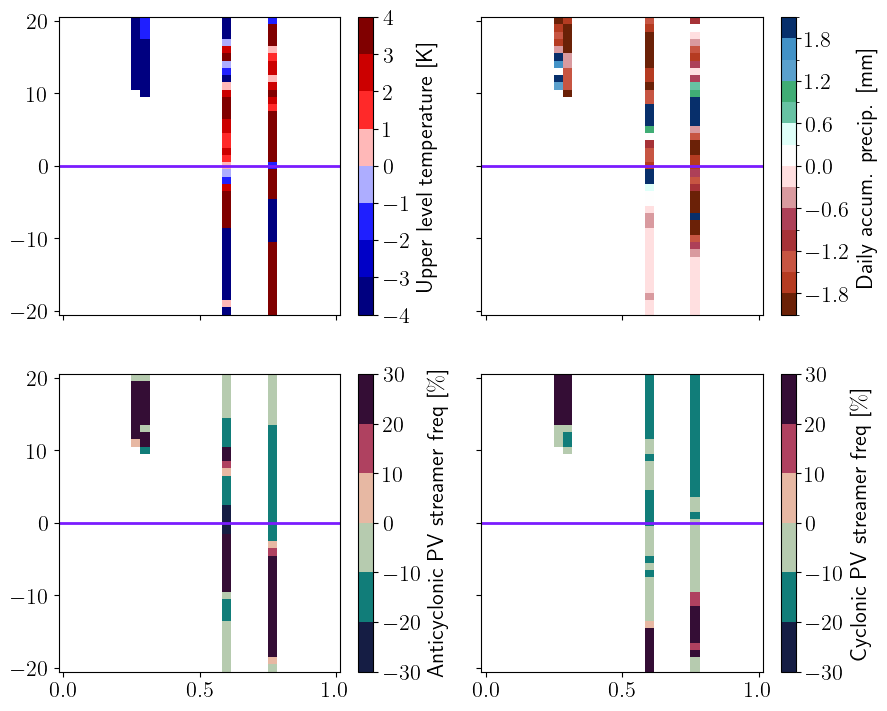

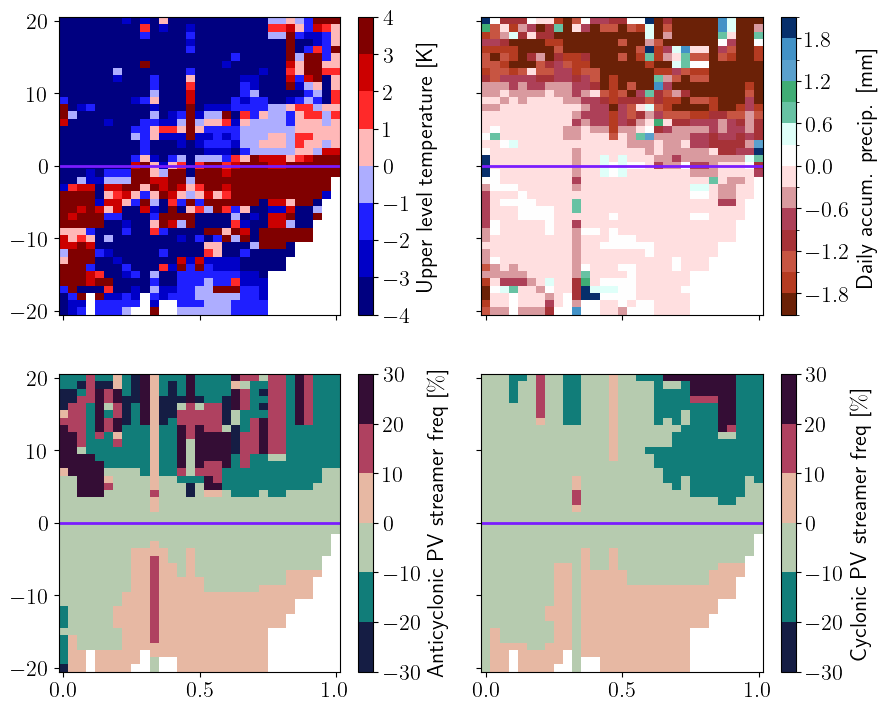

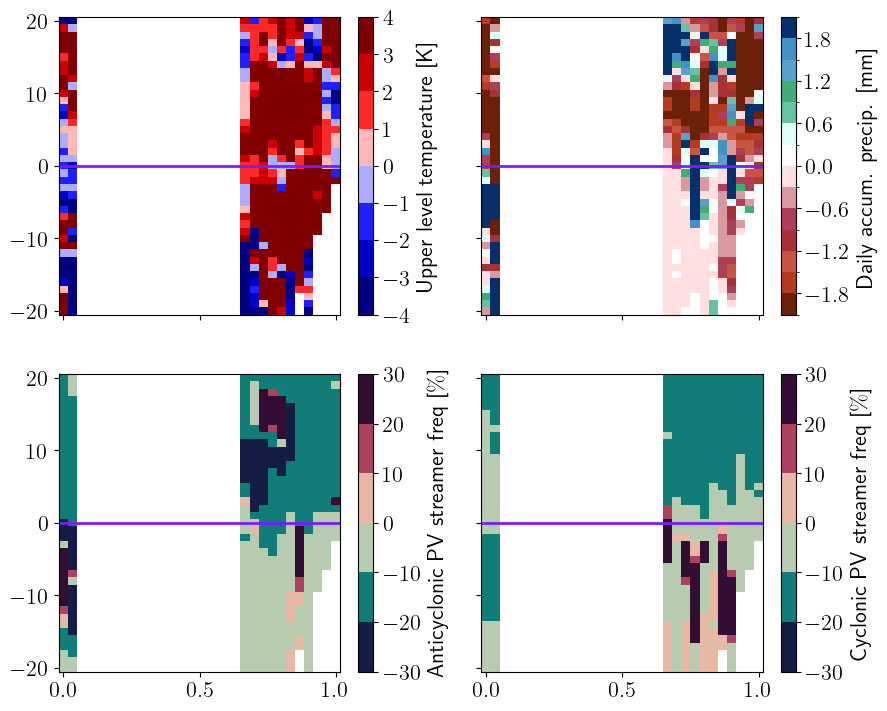

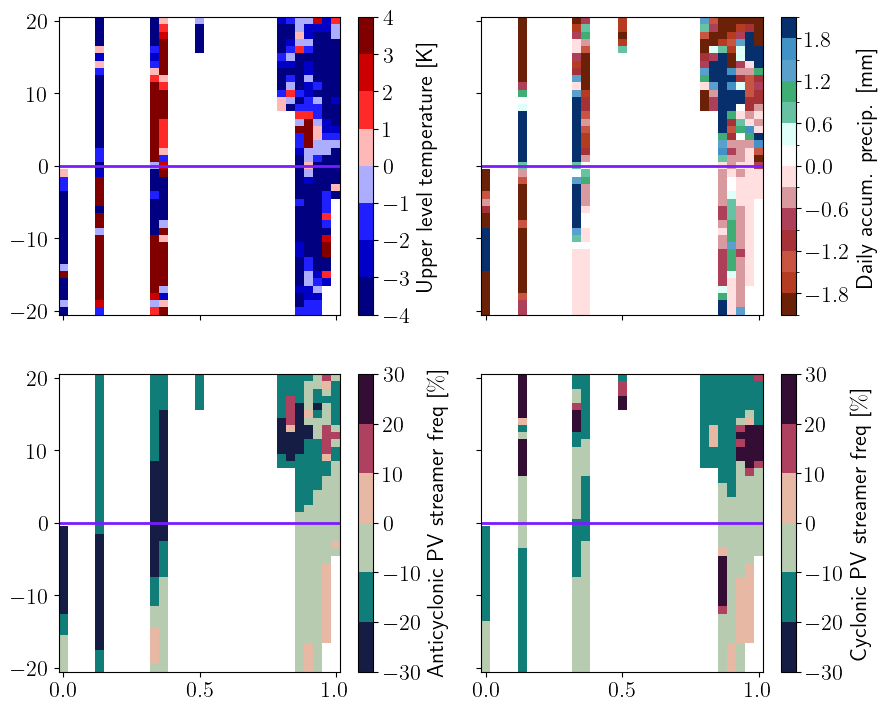

In [70]:
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("font", size=16)
plt.rc("savefig", dpi=300)
from itertools import product
spells_of = "EDJ"
spells_from_jet = spells_list[f"{spells_of} adv. spe"]
n_spells = spells_from_jet["spell"].n_unique()
for i in range(n_spells):
    spell_from_jet = spells_from_jet.filter(pl.col("spell") == i, pl.col("relative_index").is_in([0, 1, 2]))
    jets = summer_daily.rename("time").to_frame().join(all_jets_one_df, on="time")
    times = spell_from_jet
    fig, axes = plt.subplots(
        2, 2, figsize=(10, 8.5), sharex="all", sharey="all", gridspec_kw=dict(wspace=0.2)
    )
    axes = axes.ravel()
    for i, (varname, props) in enumerate(variable_dict.items()):
        ax = axes[i]
        da, nlevels, cmap, (min_, max_) = props
        clim = None
        hatch = "xxx"
        jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(
            jets.cast({"time": pl.Datetime("ms")}), times, da, n_bootstraps=0, clim=clim
        )
        to_plot = jets_during_spells_with_interp_norm_ds
        direction = infer_direction(to_plot)
        symmetric = direction == 0

        levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(
            min_, max_
        )
        norm = BoundaryNorm(levels, cmap.N)
        ax.pcolormesh(to_plot.norm_index, to_plot.n, to_plot[0].T, norm=norm, cmap=cmap)
        xlim = ax.get_xlim()
        ax.plot((-0.1, 1.1), (0, 0), lw=2, color=COLORS[1])
        ax.set_xlim(xlim)
        cbar = fig.colorbar(ScalarMappable(norm, cmap), ax=ax, spacing="proportional")
        cbar.set_label(long_names[varname], fontsize=16)
            
        #     if i == 3:  
        #         fig.supylabel("Normal distance [°]")
        #         fig.supxlabel("Relative distance along jet core")
        #         plt.draw()
        #         fig.savefig(f"{FIGURES}/jet_persistence/{spells_of}_spells_{composites_around}_composites.png")

# Relative time series

6


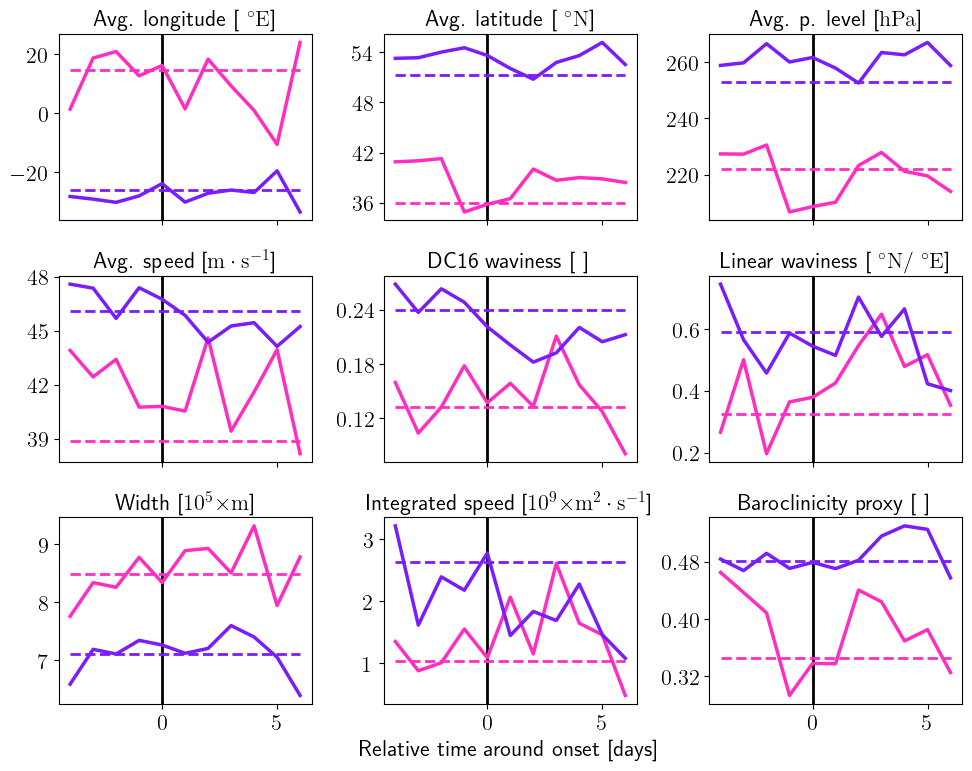

In [14]:
plt.style.use("default")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("axes", titlesize=16)
plt.rc("font", size=16)
plt.rc("text", usetex=True)
plt.rc("savefig", dpi=300)

spells_from_jet = spells_list["STJ adv. spe"]
props_masked = mask_from_spells_pl(
    spells_from_jet, props_as_df, time_before=datetime.timedelta(days=4)
)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "wavinessDC16",
    "waviness1",
    "width",
    "int",
    "ratio",
]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(
    **aggs
)
fig, axes = plt.subplots(3, 3, figsize=(10, 8), sharex="all", tight_layout=False)
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        factor = 1e5 if data_var == "width" else factor
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j], lw=2.5)
        mean = means[j, data_var] / factor
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed", lw=2)
        if j == 0:
            factor_str = "" if factor == 1 else rf"$10^{int(np.log10(factor))} \times $"
            ax.set_title(
                rf"{PRETTIER_VARNAME[data_var]} [{factor_str}{UNITS[data_var]}]"
            )
        ax.yaxis.set_major_locator(MaxNLocator(4, integer=True))
for i, ax in enumerate(axes):
    ax.axvline(0, zorder=1, color="black", lw=2)
    if i == len(axes) - 2:
        ax.set_xlabel("Relative time around onset [days]", color="black")
print(props_masked["spell"].max())
fig.set_tight_layout(True)
fig.savefig(f"{FIGURES}/jet_persistence/props_stj_persistence.png")

15


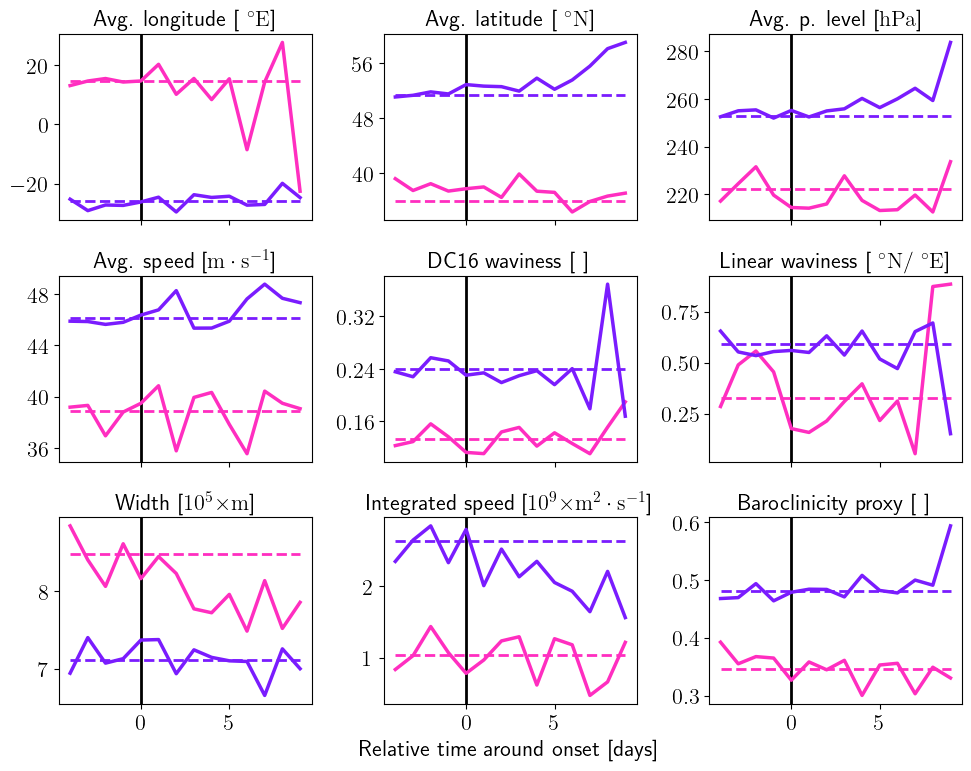

In [15]:
spells_from_jet = spells_list["EDJ adv. spe"]
props_masked = mask_from_spells_pl(
    spells_from_jet, props_as_df, time_before=datetime.timedelta(days=4)
)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))
data_vars = [
    "mean_lon",
    "mean_lat",
    "mean_lev",
    "mean_s",
    "wavinessDC16",
    "waviness1",
    "width",
    "int",
    "ratio",
]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = props_masked.group_by(["relative_index", "jet"], maintain_order=True).agg(
    **aggs
)
fig, axes = plt.subplots(3, 3, figsize=(10, 8), sharex="all", tight_layout=False)
axes = axes.ravel()
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    x = to_plot["relative_index"].unique().to_numpy()
    for ax, data_var in zip(axes, data_vars):
        factor = 1e9 if data_var in ["int_over_europe", "int"] else 1
        factor = 1e5 if data_var == "width" else factor
        ax.plot(x, to_plot[data_var] / factor, color=COLORS[2 - j], lw=2.5)
        mean = means[j, data_var] / factor
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed", lw=2)
        if j == 0:
            factor_str = "" if factor == 1 else rf"$10^{int(np.log10(factor))} \times $"
            ax.set_title(
                rf"{PRETTIER_VARNAME[data_var]} [{factor_str}{UNITS[data_var]}]"
            )
        ax.yaxis.set_major_locator(MaxNLocator(4, integer=True))
for i, ax in enumerate(axes):
    ax.axvline(0, zorder=1, color="black", lw=2)
    if i == len(axes) - 2:
        ax.set_xlabel("Relative time around onset [days]", color="black")
print(props_masked["spell"].max())
fig.set_tight_layout(True)
fig.savefig(f"{FIGURES}/jet_persistence/props_edj_persistence.png")

In [23]:
jet_da_any = jet_position_as_da(all_jets_one_df)
jet_da_EDJ = jet_position_as_da(all_jets_one_df.filter(pl.col("time").is_in(spells_list["EDJ adv. spe"]["time"])))

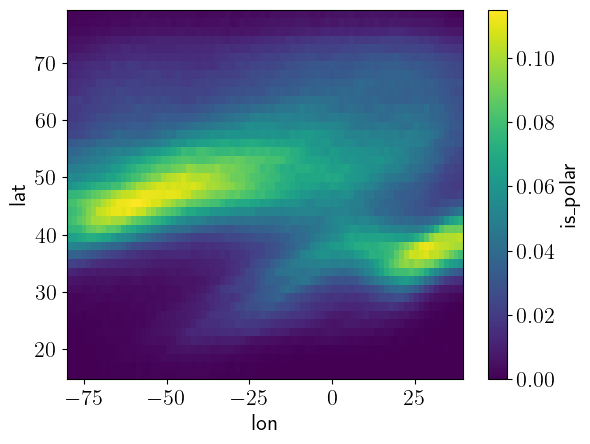

In [28]:
(jet_da_any > 0).mean("time").plot()

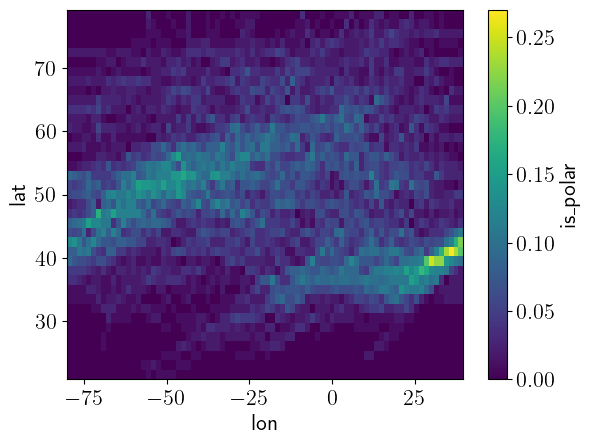

In [29]:
(jet_da_EDJ > 0).mean("time").plot()

# Props vs com speed quantiles

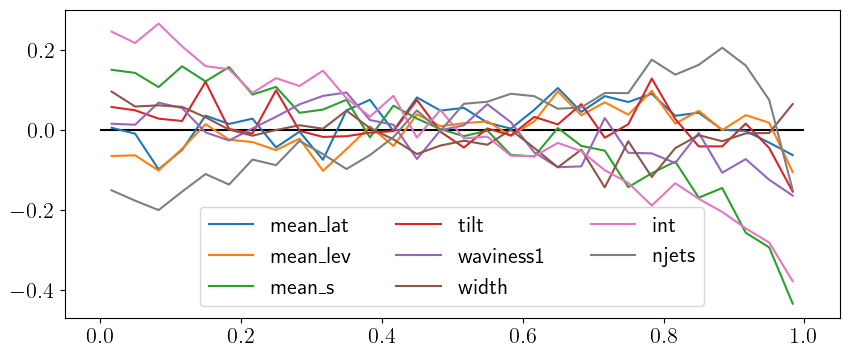

In [114]:
from itertools import pairwise
n_q = 31
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "tilt",
    "waviness1",
    "width",
    "int",
    "njets",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
com_speed = props_as_df.filter(pl.col("jet") == "EDJ")["com_speed"].replace(0.0, None)
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = ((com_speed < com_speed.quantile(q2)) & (com_speed >= com_speed.quantile(q1))).arg_true()
    props = props_as_df_anoms.filter(pl.col("jet") == "EDJ")[filter_].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
ax.hlines(0, 1, 0, colors="black")
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

In [96]:
com_speed.is_null().mean()

0.0011913104414856342

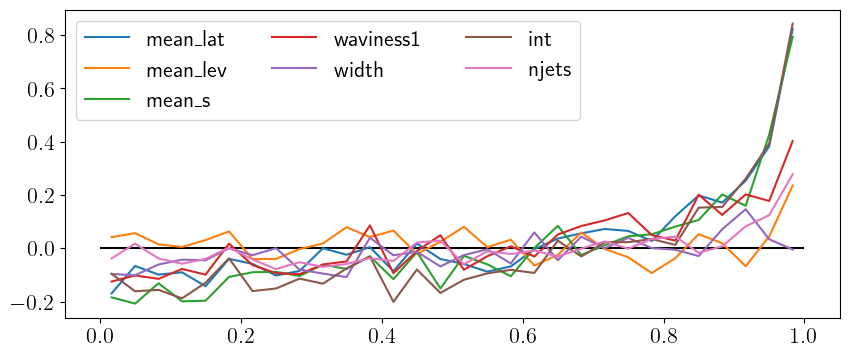

In [113]:
from itertools import pairwise
n_q = 31
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "waviness1",
    "width",
    "int",
    "njets",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
com_speed = props_as_df.filter(pl.col("jet") == "EDJ")["com_speed"].replace(0.0, None)
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = ((com_speed < com_speed.quantile(q2)) & (com_speed >= com_speed.quantile(q1))).arg_true()
    props = props_as_df_anoms.filter(pl.col("jet") == "STJ")[filter_].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
ax.hlines(0, 1, 0, colors="black")
for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

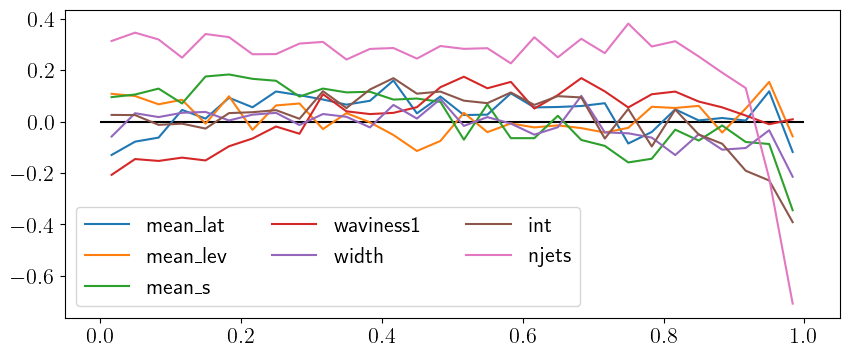

In [110]:
from itertools import pairwise
n_q = 31
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "waviness1",
    "width",
    "int",
    "njets",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
com_speed = props_as_df.filter(pl.col("jet") == "STJ")["com_speed"].replace(0.0, None)
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = ((com_speed < com_speed.quantile(q2, interpolation="linear")) & (com_speed >= com_speed.quantile(q1, interpolation="linear"))).arg_true()
    props = props_as_df_anoms.filter(pl.col("jet") == "STJ")[filter_].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
ax.hlines(0, 1, 0, colors="black")

for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

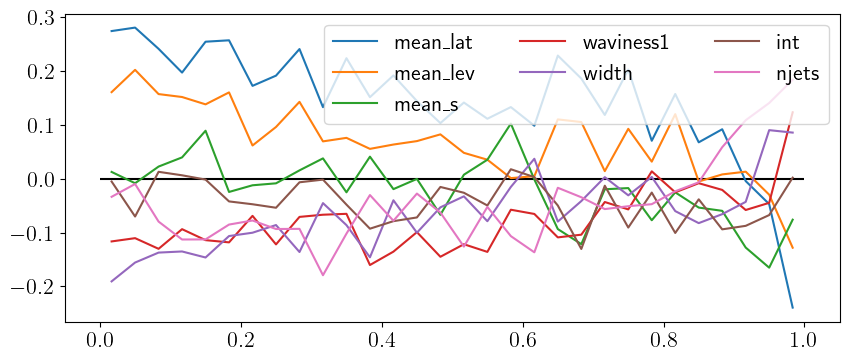

In [112]:
from itertools import pairwise
n_q = 31
data_vars = [
    "mean_lat",
    "mean_lev",
    "mean_s",
    "waviness1",
    "width",
    "int",
    "njets",
]
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
com_speed = props_as_df.filter(pl.col("jet") == "STJ")["com_speed"].replace(0.0, None)
for i, (q1, q2) in enumerate(pairwise(qs)):
    filter_ = ((com_speed < com_speed.quantile(q2)) & (com_speed >= com_speed.quantile(q1))).arg_true()
    props = props_as_df_anoms.filter(pl.col("jet") == "EDJ")[filter_].mean()
    for data_var in data_vars:
        vs_quantiles[data_var][i] = props[data_var].item()
fig, ax = plt.subplots(figsize=(10, 4))
ax.hlines(0, 1, 0, colors="black")

for data_var, to_plot in vs_quantiles.items():
    ax.plot((qs[:-1] + qs[1:]) / 2, to_plot, label=data_var)
ax.legend(ncol=3)

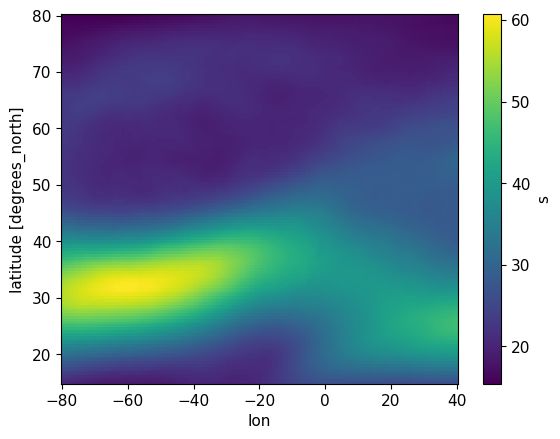

In [51]:
ds["s"][theta < np.quantile(theta, 0.01)].mean("time").plot()

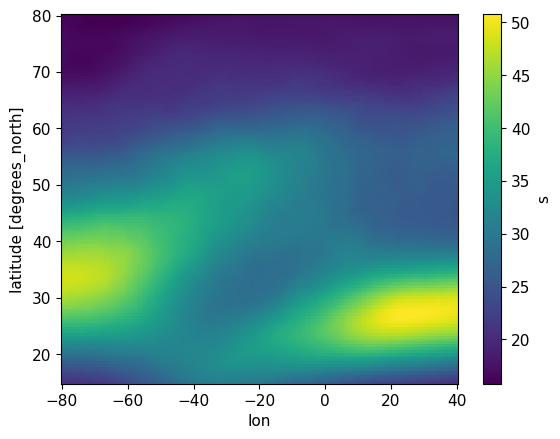

In [33]:
ds["s"][1:][spe < np.quantile(spe, 0.01)].mean("time").plot()

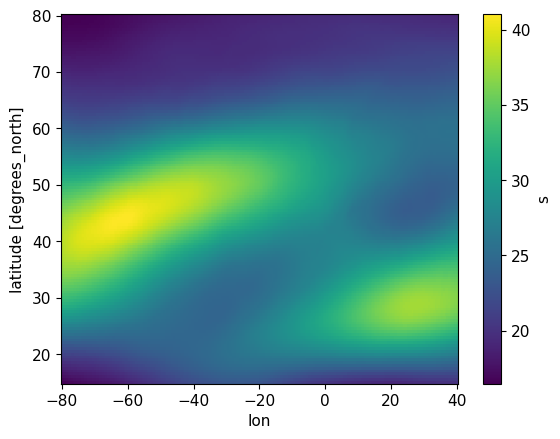

In [41]:
com_speed = props_as_df.filter(pl.col("jet") == "EDJ")["com_speed"]
ds["s"][com_speed < np.nanquantile(com_speed, 0.1)].mean("time").plot()

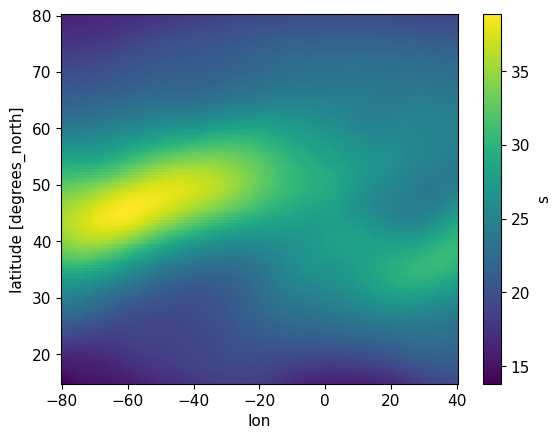

In [43]:
com_speed = props_as_df.filter(pl.col("jet") == "STJ")["com_speed"]
ds["s"][com_speed < np.nanquantile(com_speed, 0.3)].mean("time").plot()

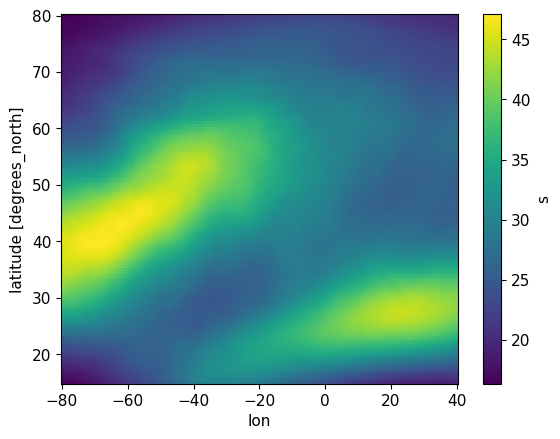

In [34]:
ds["s"][theta > np.quantile(theta, 0.99)].mean("time").plot()

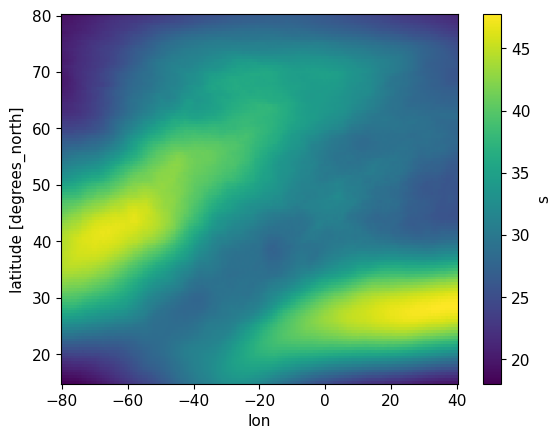

In [35]:
ds["s"][1:][spe > np.quantile(spe, 0.99)].mean("time").plot()

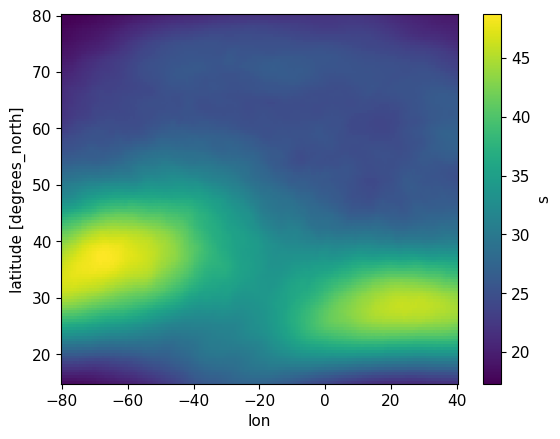

In [44]:
com_speed = props_as_df.filter(pl.col("jet") == "EDJ")["com_speed"]
ds["s"][com_speed > np.nanquantile(com_speed, 0.99)].mean("time").plot()

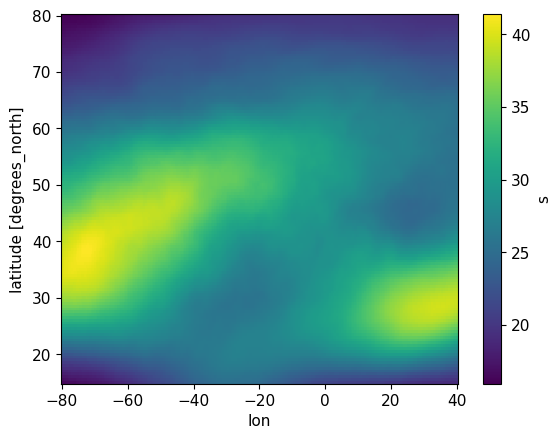

In [45]:
com_speed = props_as_df.filter(pl.col("jet") == "STJ")["com_speed"]
ds["s"][com_speed > np.nanquantile(com_speed, 0.99)].mean("time").plot()

# Relative time real space composites

In [8]:
plt.style.use("default")
plt.rc("xtick", labelsize=16)
plt.rc("ytick", labelsize=16)
plt.rc("axes", labelsize=16)
plt.rc("axes", titlesize=16)
plt.rc("font", size=16)
plt.rc("text", usetex=True)
plt.rc("savefig", dpi=300)

35
31


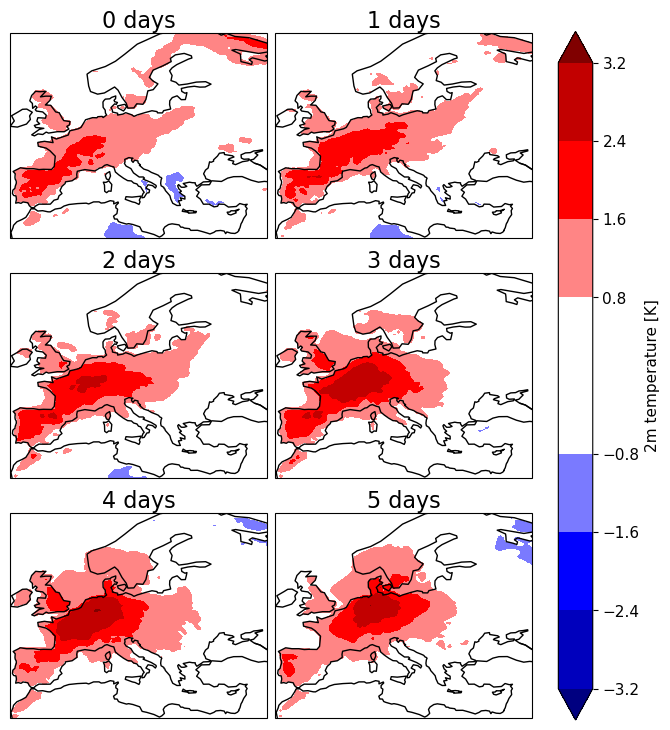

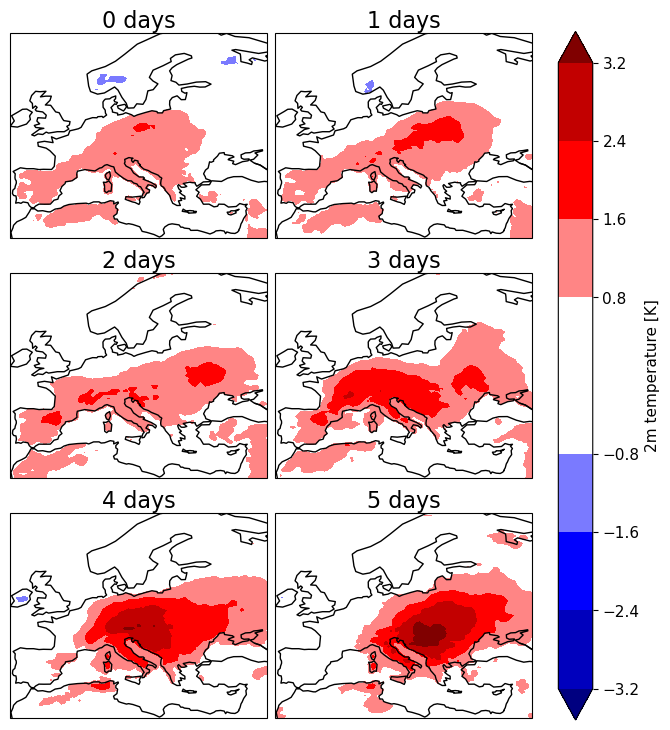

In [29]:
da = da_T.copy().sel(lon=slice(-10, 40), lat=slice(30, 70))
plot_kwargs = {"cmap": colormaps.BlWhRe, "levels": 7}

for jet in ["STJ", "EDJ"]:
    clu = Clusterplot(3, 2, get_region(da))
    spells_from_jet_daily = spells_list[f"{jet} adv. spe"]
    to_plot = mask_from_spells_pl(
        spells_from_jet_daily, da
    )
    n_spells = to_plot.spell.shape[0]
    print(n_spells)
    to_plot = to_plot.mean("spell").sel(relative_index=[0, 1, 2, 3, 4, 5])[da.name]
    _ = clu.add_contourf(
        to_plot, titles=to_plot.relative_time.values.astype("timedelta64[D]"), cbar_label=long_names[da.name], **plot_kwargs
    )
    clu.fig.savefig(f"{FIGURES}/jet_persistence/{da.name}_realspace_{jet}.png")
    clu.resize_relative([1.1, 1])

35
31


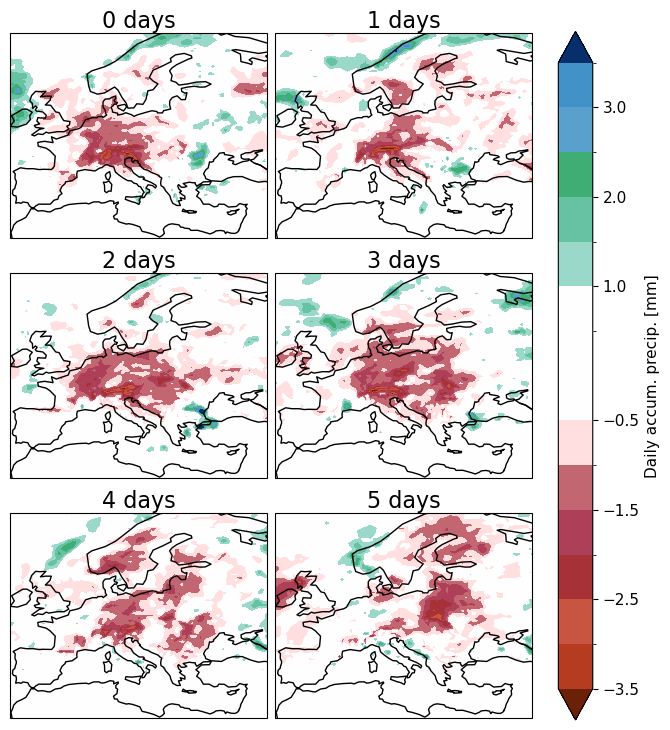

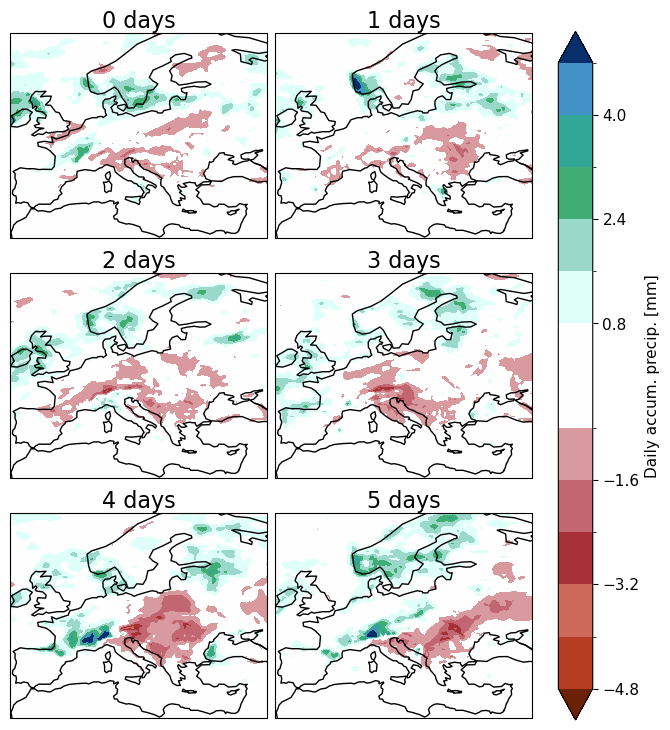

In [31]:
da = da_tp.copy().sel(lon=slice(-10, 40), lat=slice(30, 70)) * 1000
plot_kwargs = {
    "cmap": colormaps.precip4_diff_19lev,
    "levels": 13,
    "q": 0.999,
    "transparify": 0,
}

for jet in ["STJ", "EDJ"]:
    clu = Clusterplot(3, 2, get_region(da))
    spells_from_jet_daily = spells_list[f"{jet} adv. spe"]
    to_plot = mask_from_spells_pl(
        spells_from_jet_daily, da
    )
    n_spells = to_plot.spell.shape[0]
    print(n_spells)
    to_plot = to_plot.mean("spell").sel(relative_index=[0, 1, 2, 3, 4, 5])[da.name]
    _ = clu.add_contourf(
        to_plot, titles=to_plot.relative_time.values.astype("timedelta64[D]"), cbar_label=long_names[da.name], **plot_kwargs
    )
    clu.fig.savefig(f"{FIGURES}/jet_persistence/{da.name}_realspace_{jet}.png")
    clu.resize_relative([1.1, 1])

35
31


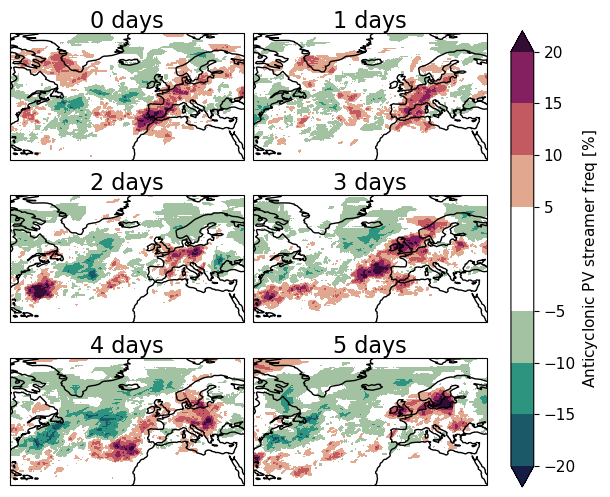

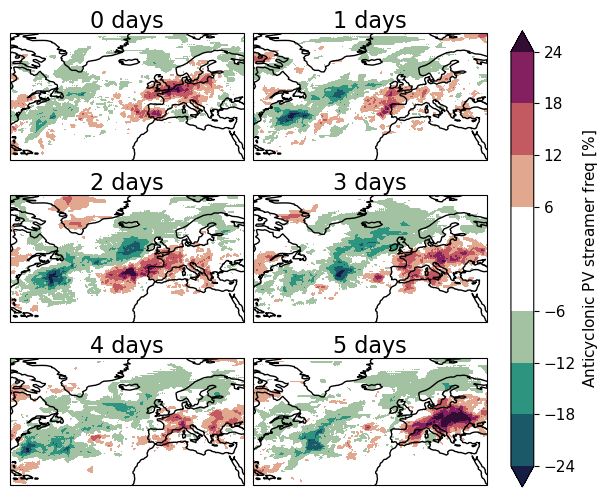

In [32]:
da = da_apvs.copy() * 100
plot_kwargs = {
    "cmap": colormaps.curl,
    "levels": 7,
    "transparify": 1,
}

for jet in ["STJ", "EDJ"]:
    clu = Clusterplot(3, 2, get_region(da))
    spells_from_jet_daily = spells_list[f"{jet} adv. spe"]
    to_plot = mask_from_spells_pl(
        spells_from_jet_daily, da
    )
    n_spells = to_plot.spell.shape[0]
    print(n_spells)
    to_plot = to_plot.mean("spell").sel(relative_index=[0, 1, 2, 3, 4, 5])[da.name]
    _ = clu.add_contourf(
        to_plot, titles=to_plot.relative_time.values.astype("timedelta64[D]"), cbar_label=long_names[da.name], **plot_kwargs
    )
    clu.fig.savefig(f"{FIGURES}/jet_persistence/{da.name}_realspace_{jet}.png")

35
31


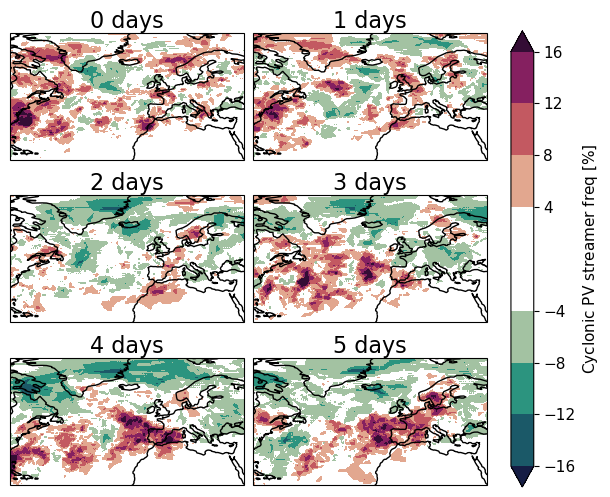

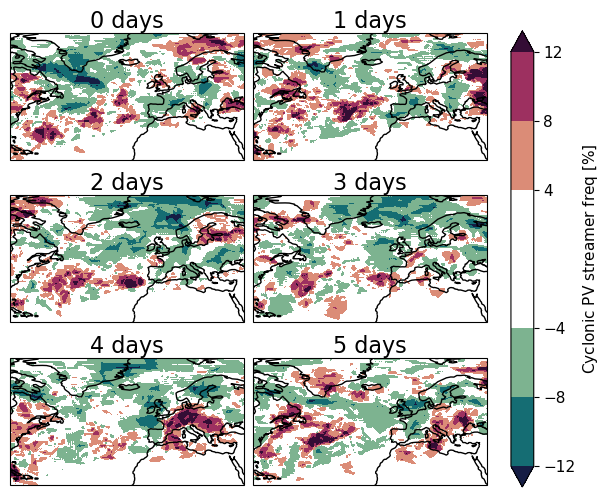

In [33]:
da = da_cpvs.copy() * 100
plot_kwargs = {
    "cmap": colormaps.curl,
    "levels": 7,
    "transparify": 1,
}

for jet in ["STJ", "EDJ"]:
    clu = Clusterplot(3, 2, get_region(da))
    spells_from_jet_daily = spells_list[f"{jet} adv. spe"]
    to_plot = mask_from_spells_pl(
        spells_from_jet_daily, da
    )
    n_spells = to_plot.spell.shape[0]
    print(n_spells)
    to_plot = to_plot.mean("spell").sel(relative_index=[0, 1, 2, 3, 4, 5])[da.name]
    _ = clu.add_contourf(
        to_plot, titles=to_plot.relative_time.values.astype("timedelta64[D]"), cbar_label=long_names[da.name], **plot_kwargs
    )
    clu.fig.savefig(f"{FIGURES}/jet_persistence/{da.name}_realspace_{jet}.png")